# Transactions - Time Series Modelling

In [185]:
import os

import joblib
import numpy as np
import pandas as pd
import skops.io as sio
from tqdm import tqdm
import warnings

from helpers import (
    CHARTS_DIR, TRANSFORMED_DATA_DIR
)

## Load integrated data

In [186]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt7_integrated.parquet')
df_transactions.head()

,township,building_type,tenure,...,n_crimes,date,interest_rate
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,...,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,...,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,...,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,...,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,...,8770.0,2000-01-02,5.5


In [187]:
df_transactions.columns

Index(['township', 'building_type', 'tenure', 'floors', 'rooms', 'land_area',
       'built_up', 'price_psf', 'price', 'year', 'month', 'day', 'cpi',
       'median_income', 'mean_income', 'n_households', 'wellbeing_index',
       'money_supply_millions', 'unemployment_rate', 'population_thousands',
       'n_crimes', 'date', 'interest_rate'],
      dtype='object')

## Data splitting

In [195]:
df_transactions = df_transactions.sort_values(by=['date'])
df_transactions.head()

,township,building_type,tenure,...,n_crimes,date,interest_rate
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,...,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,...,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,...,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,...,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,...,8770.0,2000-01-02,5.5


In [196]:
df_train = df_transactions.query('year <= 2020')
df_train['year'].value_counts().sort_index()


year
2000.0     6470
2001.0     6494
2002.0     7547
2003.0     8379
2004.0    10449
2005.0     9382
2006.0     8990
2007.0    11603
2008.0    11943
2009.0    13817
2010.0    13409
2011.0    14156
2012.0    12561
2013.0    14271
2014.0    12335
2015.0     9877
2016.0     8573
2017.0     9371
2018.0     8758
2019.0     7388
2020.0     6775
Name: count, dtype: int64

In [197]:
df_test = df_transactions.query('year >= 2021')
df_test['year'].value_counts().sort_index()

year
2021.0    7492
2022.0    8136
2023.0    2098
Name: count, dtype: int64

## Pre-modelling visualisation

Raw data contains 200k data, across 24 years (2000 - 2023). This means that there will be multiple data points for each date (timestamp). In order for traditional time series modelling to work, we need to aggregate the data. In this case, we try to aggregate the data by year, month and day.

In [198]:
df_yearly_price_psf_train = df_train[['year', 'price_psf']]
df_monthly_price_psf_train = df_train[['year', 'month', 'price_psf']]
df_daily_price_psf_train = df_train[['date', 'price_psf']]

### Aggregating data by year

<Axes: title={'center': 'Mean and Median Price per Square Feet per Year'}, xlabel='year'>

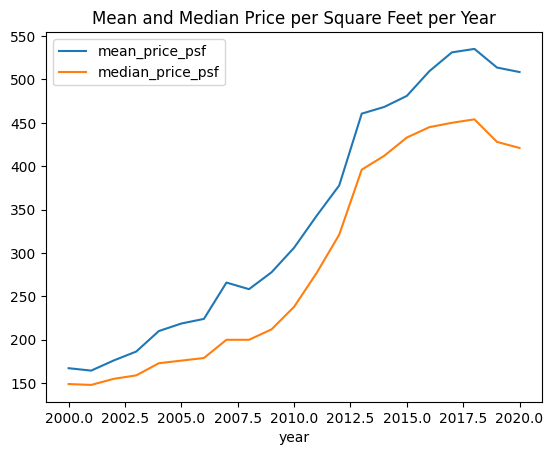

In [199]:
mean_yearly_price_psf_train = df_yearly_price_psf_train.groupby('year').mean()
median_yearly_price_psf_train = df_yearly_price_psf_train.groupby('year').median()

df_price_psf_per_year_train = pd.concat([mean_yearly_price_psf_train, median_yearly_price_psf_train], axis=1)
df_price_psf_per_year_train.columns = ['mean_price_psf', 'median_price_psf']

df_price_psf_per_year_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Year',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

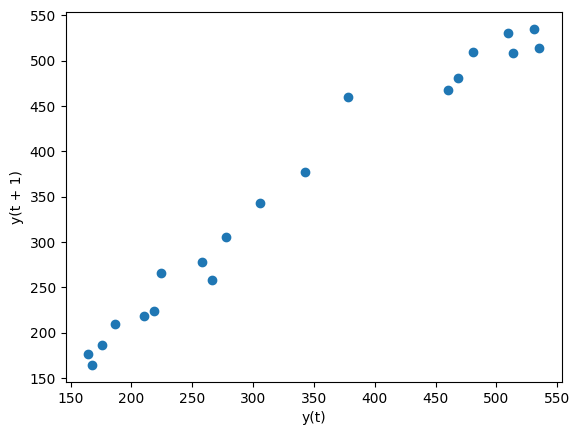

In [200]:
from pandas.plotting import autocorrelation_plot, lag_plot

lag_plot(mean_yearly_price_psf_train['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

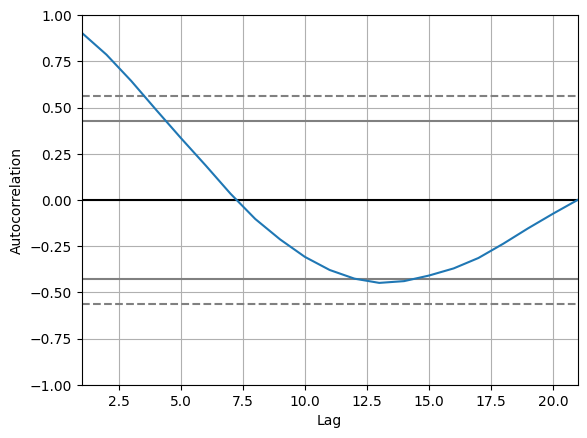

In [201]:
autocorrelation_plot(mean_yearly_price_psf_train['price_psf'])

Although the aggregated data has a reasonable time plot, there were only 21 data points. This is not enough for time series modelling. Further granulatity is required.

### Aggregating data by month

In [202]:
df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1)) 
df_monthly_price_psf_train.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_6396\447924927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1))


,year,month,price_psf,year_month
34996,2000.0,1.0,128.0,2000-01-01
34997,2000.0,1.0,122.0,2000-01-01
34998,2000.0,1.0,122.0,2000-01-01
34999,2000.0,1.0,120.0,2000-01-01
35000,2000.0,1.0,180.0,2000-01-01


Number of months from 2000 to 2020: 252
Length of grouped dataframe: 252


<Axes: title={'center': 'Mean and Median Price per Square Feet per Month'}, xlabel='year_month'>

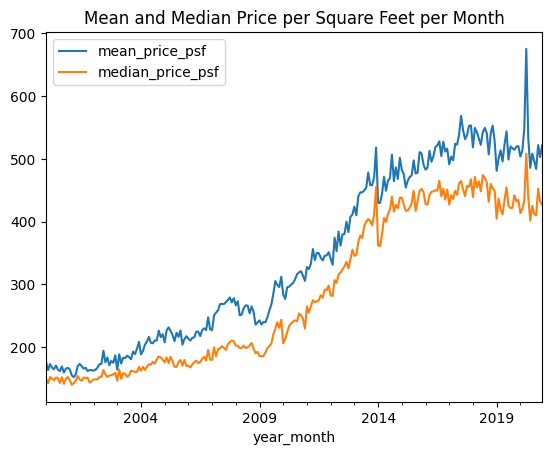

In [203]:
mean_monthly_price_psf_train = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').mean()
median_monthly_price_psf_train = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').median()

df_price_psf_per_month_train = pd.concat([mean_monthly_price_psf_train, median_monthly_price_psf_train], axis=1)
df_price_psf_per_month_train.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of months from 2000 to 2020: {12 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_month_train)}')

df_price_psf_per_month_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

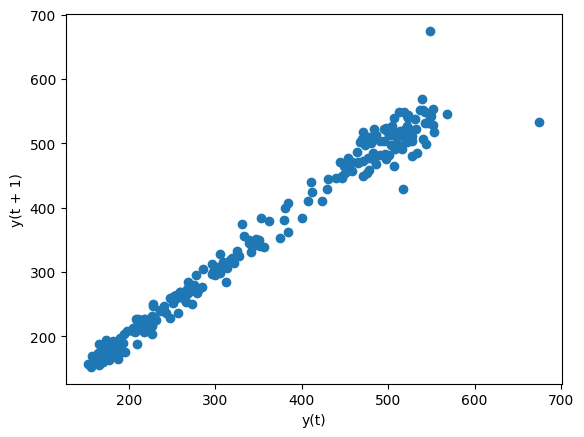

In [204]:
lag_plot(mean_monthly_price_psf_train['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

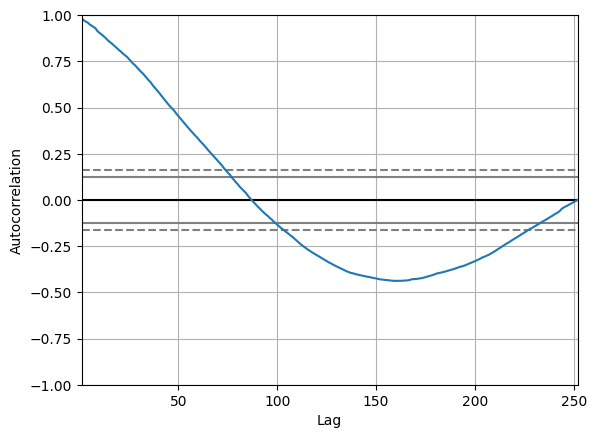

In [205]:
autocorrelation_plot(mean_monthly_price_psf_train['price_psf'])

By aggregating the data by month, we have 252 data points. This is a reasonable amount of data points for time series modelling. However, let's try to aggregate the data by day and see if this is a better option.

Moreover, the lag plot shows that there is a strong correlation between the current month's `price_psf` and the previous month's `price_psf`. This is a good sign for time series modelling.

### Aggregating data by date

Number of days from 2000 to 2020: 7665
Length of grouped dataframe: 7093


<Axes: title={'center': 'Mean and Median Price per Square Feet per Day'}, xlabel='date'>

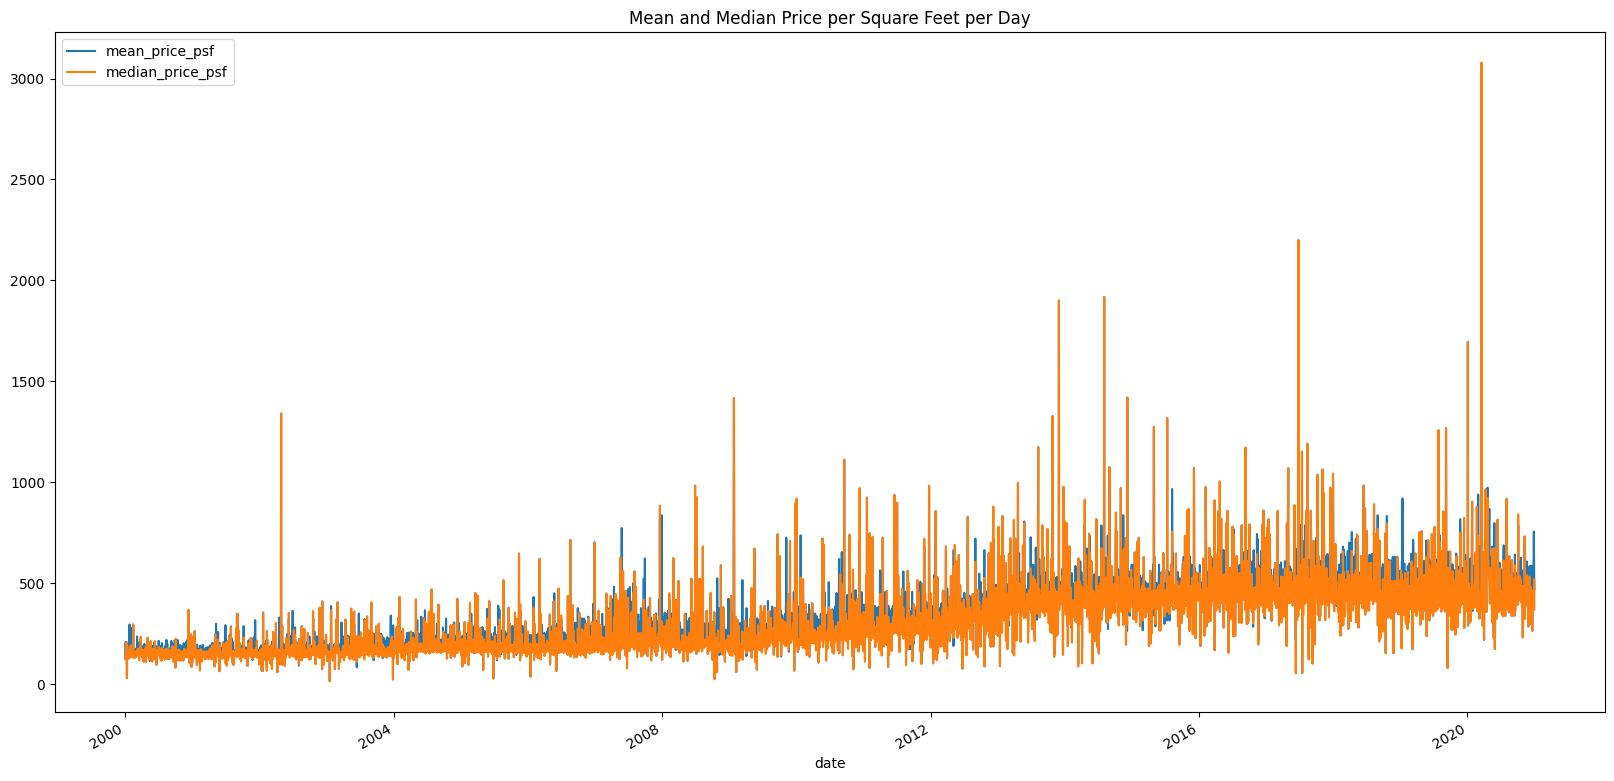

In [206]:
mean_daily_price_psf_train = df_daily_price_psf_train.groupby('date').mean()
median_daily_price_psf_train = df_daily_price_psf_train.groupby('date').median()

df_price_psf_per_day_train = pd.concat([mean_daily_price_psf_train, median_daily_price_psf_train], axis=1)
df_price_psf_per_day_train.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of days from 2000 to 2020: {365 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_day_train)}')

df_price_psf_per_day_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Day',
    figsize=(20, 10)
)

There should be a minimum of 7665 transactions (one transaction per day) but we only have 7093 transactions. This means that there are days with no transactions.

Additionally, based on the chart above, there are more than one transaction per day.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

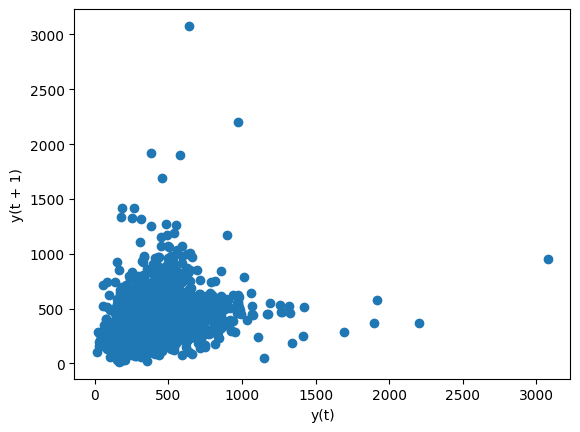

In [207]:
lag_plot(mean_daily_price_psf_train['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

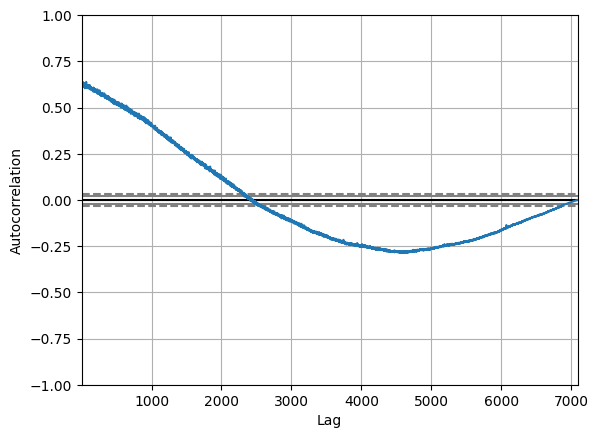

In [208]:
autocorrelation_plot(mean_daily_price_psf_train['price_psf'])

Although aggregating the data by day gives us the most granular data, the lag plot is fairly dispersed and there is no clear correlation between the current day's `price_psf` and the previous day's `price_psf`. This is not a good sign for time series modelling.

Moving forward, we will use monthly data for forecasting.

## Time series modelling

From the literature, the most popular methods are:
- Time series methods:
    1. ARIMA (Abidoye et al., 2019; Dejniak & Dąbrowski, 2017; Iliychovski et al., 2022; Y. Li et al., 2020; Liu & Wu, 2020; Samadani & Costa, 2021)
    2. SARIMA (Samadani & Costa, 2021)
    3. Holt’s exponential smoothing (Liu & Wu, 2020)
- Machine learning approaches :
    1. random forest regression (Ayyasamy et al., 2022)
    2. support vector regression (Ayyasamy et al., 2022; D.-Y. Li et al., 2009; Y. Li et al., 2020; Plakandaras et al., 2015)
    3. neural networks (Abidoye et al., 2019; Kang et al., 2020; Liu & Wu, 2020; Sa’at et al., 2021; Samadani & Costa, 2021; Xu & Zhang, 2021)

These techniques will be implemented in this study as they were not completely compared against each other in the prior studies.

As this is a time series study, traditional cross validation approach is unsuitable due to time dependencies. Bergmeir & Benítez (2012) suggested the use of blocked cross validation, where the time series data is divided into consecutive segments with fixed number of data points. In each segment, the data is divided into training and validation set. In this way, each data point is fully utilised.

There are two time series data in this study: mean price per square feet and median price per square feet. In the following analysis, we will perform time series modelling on mean price per square feet then followed by median price per square feet.

Let's check the normality, autocorrelation and partial autocorrelation of the time series.

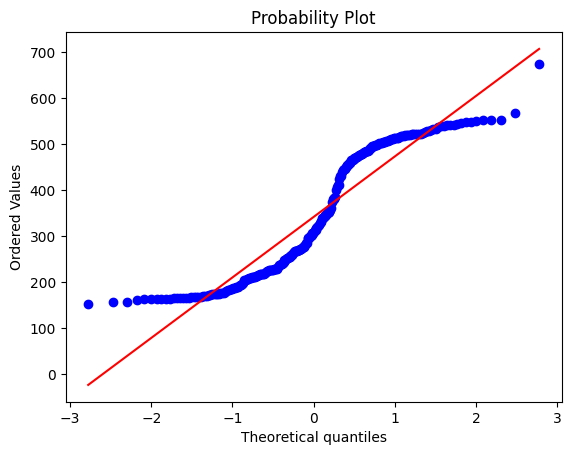

In [209]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

probplot(mean_monthly_price_psf_train['price_psf'], plot=plt)
plt.show()

The time series is not normally distributed. This is expected for time series.

Let's check if the data is stationary.

In [210]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [211]:
from statsmodels.tsa.stattools import adfuller

mean_monthly_price_psf_adf_result = adfuller(mean_monthly_price_psf_train)
print_adf_result(mean_monthly_price_psf_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.717107
P-Value                   0.842268
# Lags Used              15.000000
# Observations Used     236.000000
Critical Value (1%)      -3.458366
Critical Value (5%)      -2.873866
Critical Value (10%)     -2.573339
dtype: float64


In [212]:
median_monthly_price_psf_adf_result = adfuller(median_monthly_price_psf_train)
print_adf_result(median_monthly_price_psf_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.356427
P-Value                   0.917124
# Lags Used               6.000000
# Observations Used     245.000000
Critical Value (1%)      -3.457326
Critical Value (5%)      -2.873410
Critical Value (10%)     -2.573096
dtype: float64


The Augmented Dickey-Fuller (ADF) test is to test for stationarity. The null hypothesis H0 is that the time series is non-stationary, while the alternative hypothesis H1 is that the time series is stationary.

Since the computed p-value is more than 0.05, we fail to reject the null hypothesis H0 and conclude that the time series is non-stationary. We need to perform differencing as time series models like ARIMA expects the data series to be stationary. We can use the STL method to perform differencing or deseasonalising. However, we need to specify the period.

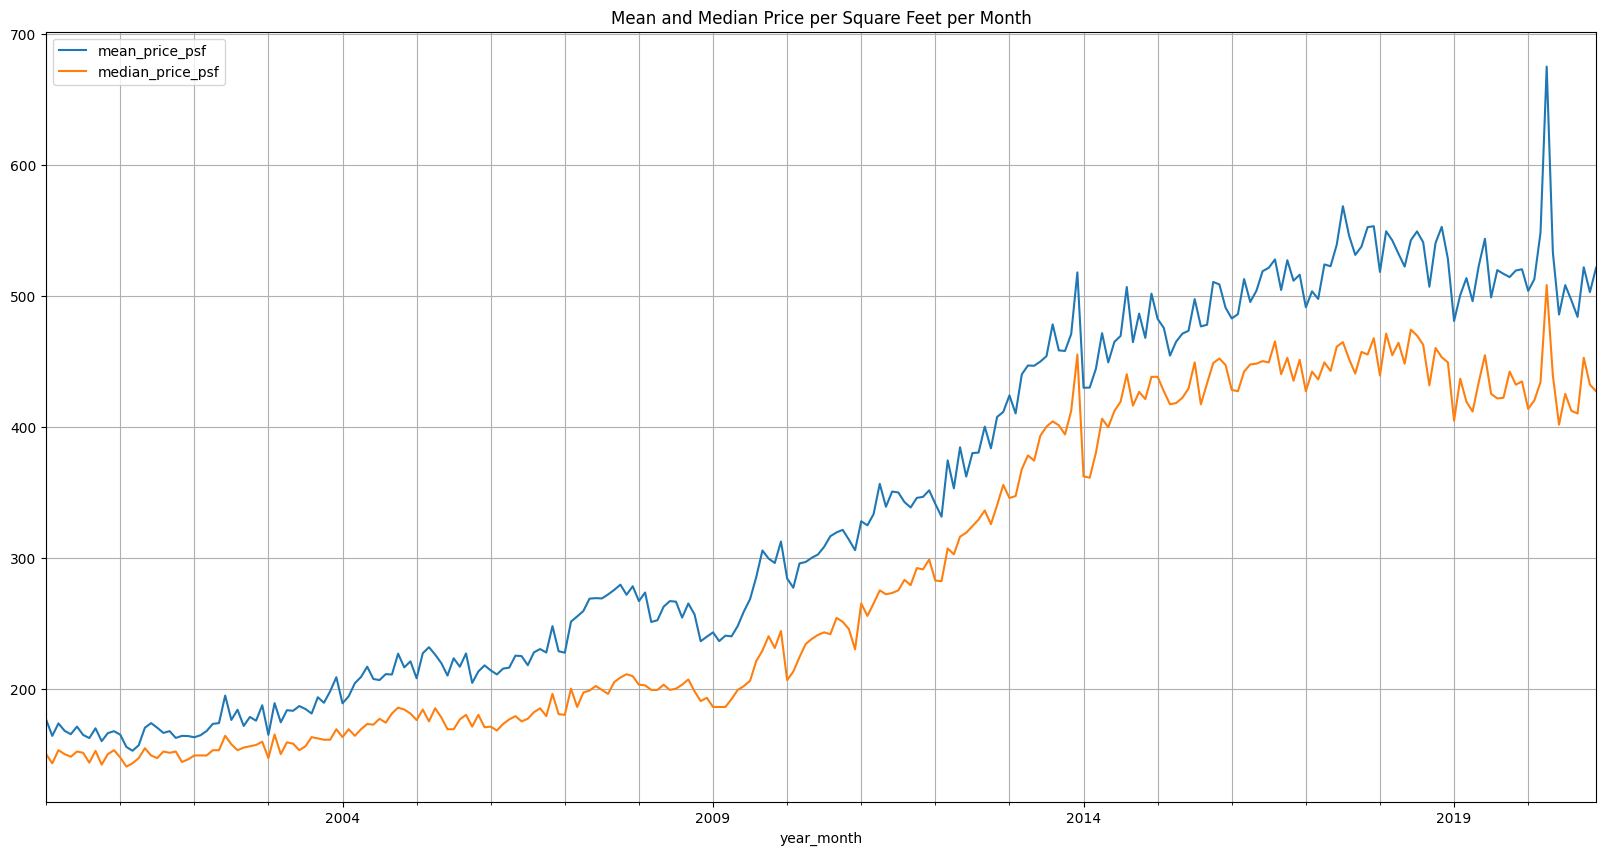

In [213]:
df_price_psf_per_month_train.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month',
    figsize=(20, 10),
    grid=True,
)
plt.grid(which='minor', axis='x')
plt.show()

In [214]:
print(f'The inferred frequency of monthly price psf is: {median_monthly_price_psf_train.index.inferred_freq}')

The inferred frequency of monthly price psf is: MS


Since this is a monthly data, we take the period to be 12 months. Let's perform decomposition and check the trend, seasonality and residuals.

### STL decomposition

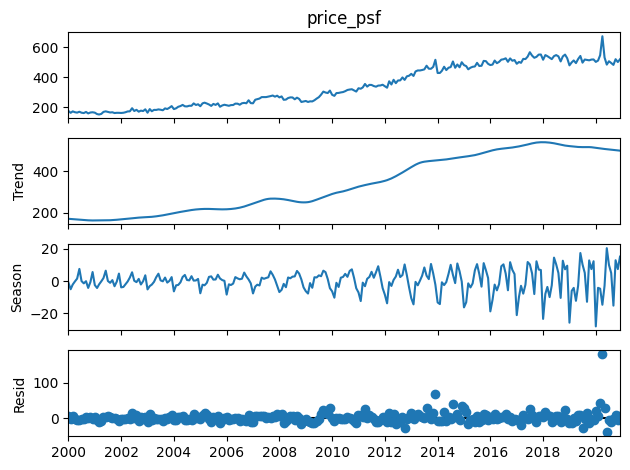

In [215]:
from statsmodels.tsa.seasonal import STL

mean_price_psf_stl = STL(mean_monthly_price_psf_train['price_psf'], period=12, robust=True, seasonal=13).fit()
mean_price_psf_stl.plot()
plt.show()

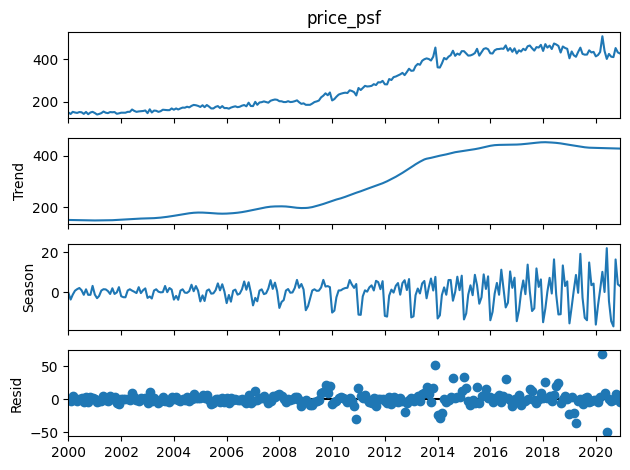

In [216]:
median_price_psf_stl = STL(median_monthly_price_psf_train['price_psf'], period=12, robust=True, seasonal=13).fit()
median_price_psf_stl.plot()
plt.show()

We will model both mean and median price per square feet.

Based on STL decomposition, there are increasing trend and seasonality:
1. The trend is flat until 2004, where it started to increase steadily until 2018. Then it plateaued until 2020.
2. The seasonality is flat until 2008, where it started to increase slightly at 2012. Seasonality spiked at 2019 onwards.
3. No pattern is spotted for residuals. However, there could be some noise at 2014, 2019 and 2020.

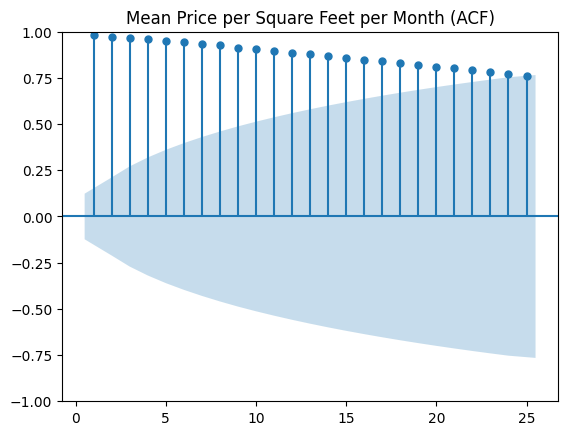

In [217]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(mean_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Mean Price per Square Feet per Month (ACF)')
plt.show()

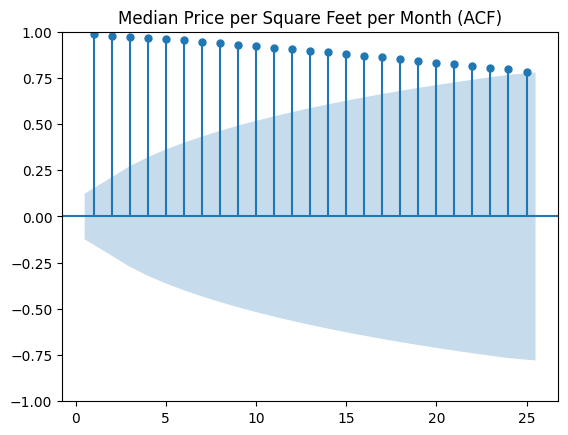

In [218]:
plot_acf(median_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Median Price per Square Feet per Month (ACF)')
plt.show()

Based on the ACF plot, there are statistically significant lag from 1 to 24. This means that the monthly `price_psf` are highly correlated with each other. When the `price_psf` increases, it tends to continue rising; conversely, if it falls, it tends to continue to fall:
1. Might suggest a seasonal pattern with a periodicity of 24 time points (2 years)
2. May indicate that differencing is needed to achieve stationarity
3. Consider decomposing time series into its trend, seasonal, and residual components using methods like seasonal decomposition of time series (STL)
4. Evaluate fitted models using metrics like AIC or BIC

Let's perform differencing using `period=1` and `periods=2` and check if the differenced time series is stationary.

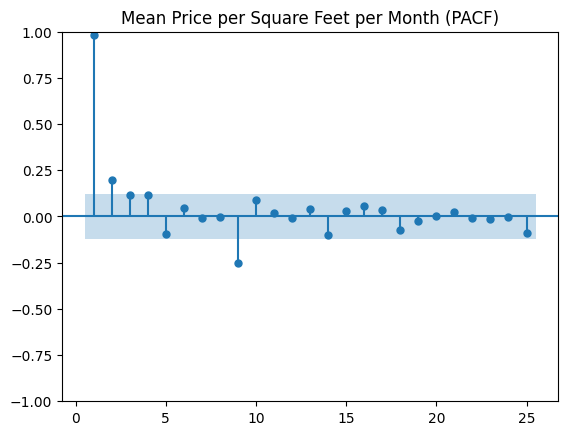

In [219]:
plot_pacf(mean_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Mean Price per Square Feet per Month (PACF)')
plt.show()

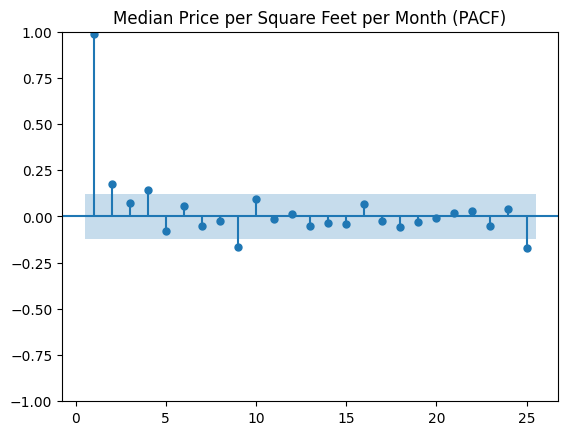

In [220]:
plot_pacf(median_monthly_price_psf_train['price_psf'], zero=False)
plt.title('Median Price per Square Feet per Month (PACF)')
plt.show()

In the original time series, the PACF plot shows statistically significant coefficient up to lag 2 for both mean and median `price_psf`. This means that the monthly `price_psf` are correlated with each other up to 2 months. 

### Differenced with `period=1`

In [221]:
mean_monthly_price_psf_train_diff_1 = mean_monthly_price_psf_train.diff(1).dropna()
mean_monthly_price_psf_train_diff_1_adf_result = adfuller(mean_monthly_price_psf_train_diff_1)
print_adf_result(mean_monthly_price_psf_train_diff_1_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.227672
P-Value                   0.000591
# Lags Used              14.000000
# Observations Used     236.000000
Critical Value (1%)      -3.458366
Critical Value (5%)      -2.873866
Critical Value (10%)     -2.573339
dtype: float64


In [222]:
median_monthly_price_psf_train_diff_1 = median_monthly_price_psf_train.diff(1).dropna()
median_monthly_price_psf_train_diff_1_adf_result = adfuller(median_monthly_price_psf_train_diff_1)
print_adf_result(median_monthly_price_psf_train_diff_1_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.495187e+00
P-Value                 4.398666e-11
# Lags Used             5.000000e+00
# Observations Used     2.450000e+02
Critical Value (1%)    -3.457326e+00
Critical Value (5%)    -2.873410e+00
Critical Value (10%)   -2.573096e+00
dtype: float64


For differenced mean monthly price psf, the p-value of ADF test is less than 0.05, therefore we reject the null hypothesis H0 and conclude that the differenced time series is stationary.

Let's check the autocorrelation and partial autocorrelation of the original and differenced time series.

[]

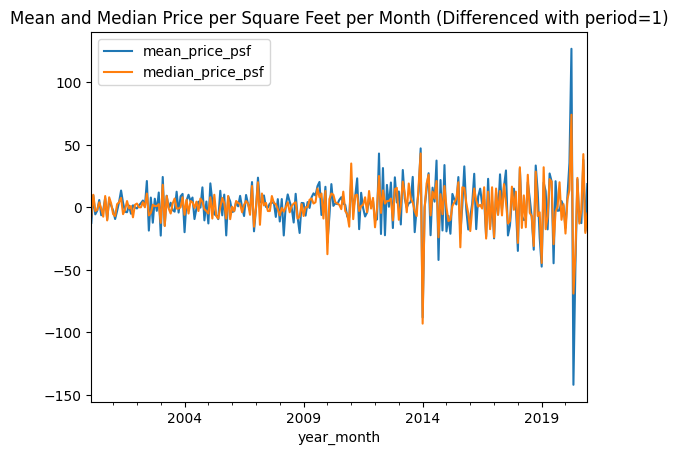

In [223]:
df_monthly_price_psf_train_diff_1 = pd.concat([mean_monthly_price_psf_train_diff_1, median_monthly_price_psf_train_diff_1], axis=1)
df_monthly_price_psf_train_diff_1.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (Differenced with period=1)',
)
plt.legend(['mean_price_psf', 'median_price_psf'])
plt.plot()

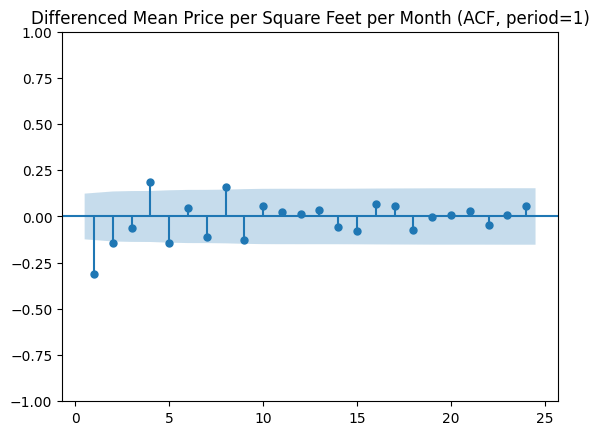

In [224]:
plot_acf(mean_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (ACF, period=1)')
plt.show()

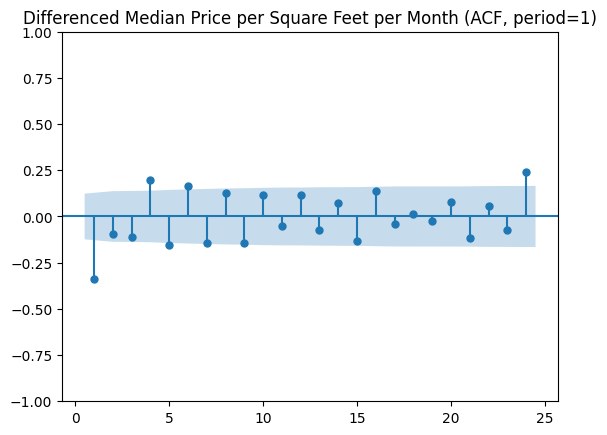

In [225]:
plot_acf(median_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (ACF, period=1)')
plt.show()

After differencing with period of 1, the ACF plot shows statistically significant coefficient up to lag 2 for mean `price_psf` and lag 1 for median `price_psf`. This means that we can use `q=2` for ARIMA model on mean `price_psf` and `q=1` for median `price_psf`.

Let's do the same for PACF.

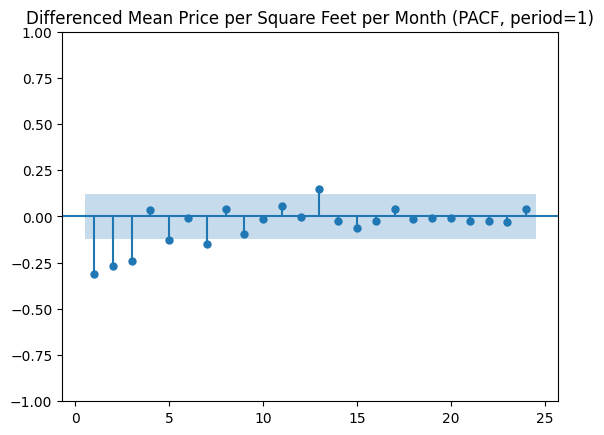

In [226]:
plot_pacf(mean_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (PACF, period=1)')
plt.show()

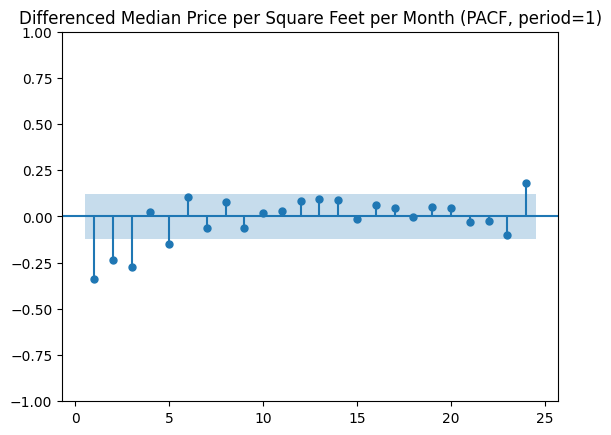

In [227]:
plot_pacf(median_monthly_price_psf_train_diff_1, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (PACF, period=1)')
plt.show()

However, differenced time series shows statistically significant coefficient up to lag 3 for both mean and median `price_psf`. This means that we can use `p=3` for ARIMA model on both time series data.

For ARIMA model, we can use the following configurations:
- Mean `price_psf`: (p, d, q) = (3, 1, 2)
- Median `price_psf`: (p, d, q) = (3, 1, 1)

Let's try with `period=2` and check if the differenced time series is stationary.

### Differenced with `period=2`

In [228]:
mean_monthly_price_psf_train_diff_2 = mean_monthly_price_psf_train.diff(2).dropna()
mean_monthly_price_psf_train_diff_2_adf_result = adfuller(mean_monthly_price_psf_train_diff_2)
print_adf_result(mean_monthly_price_psf_train_diff_2_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.313496
P-Value                   0.000421
# Lags Used              13.000000
# Observations Used     236.000000
Critical Value (1%)      -3.458366
Critical Value (5%)      -2.873866
Critical Value (10%)     -2.573339
dtype: float64


In [229]:
median_monthly_price_psf_train_diff_2 = median_monthly_price_psf_train.diff(2).dropna()
median_monthly_price_psf_train_diff_2_adf_result = adfuller(median_monthly_price_psf_train_diff_2)
print_adf_result(median_monthly_price_psf_train_diff_2_adf_result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.137288
P-Value                   0.023914
# Lags Used              12.000000
# Observations Used     237.000000
Critical Value (1%)      -3.458247
Critical Value (5%)      -2.873814
Critical Value (10%)     -2.573311
dtype: float64


For differenced mean monthly price psf, the p-value of ADF test is less than 0.05, therefore we reject the null hypothesis H0 and conclude that the differenced time series is stationary. Although the differenced median monthly price psf is much higher than the mean monthly price psf, the p-value of ADF test is less than 0.05, therefore we reject the null hypothesis H0 and conclude that the differenced time series is stationary.

Let's check the autocorrelation and partial autocorrelation of the differenced time series.

[]

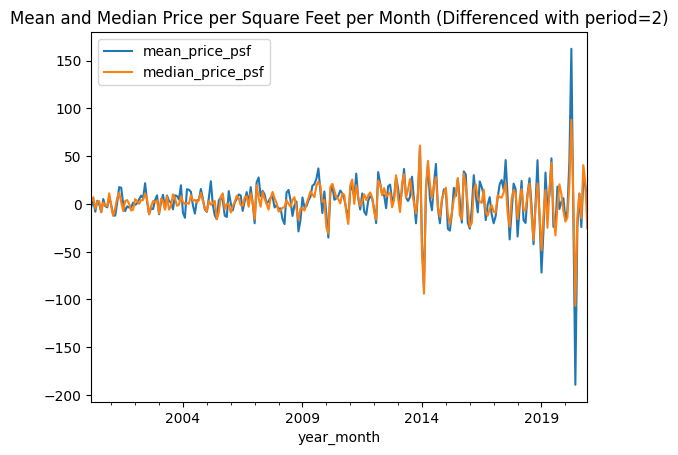

In [230]:
df_monthly_price_psf_train_diff_2 = pd.concat([mean_monthly_price_psf_train_diff_2, median_monthly_price_psf_train_diff_2], axis=1)
df_monthly_price_psf_train_diff_2.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (Differenced with period=2)',
)
plt.legend(['mean_price_psf', 'median_price_psf'])
plt.plot()

Let's plot the ACF and PACF of the differenced time series.

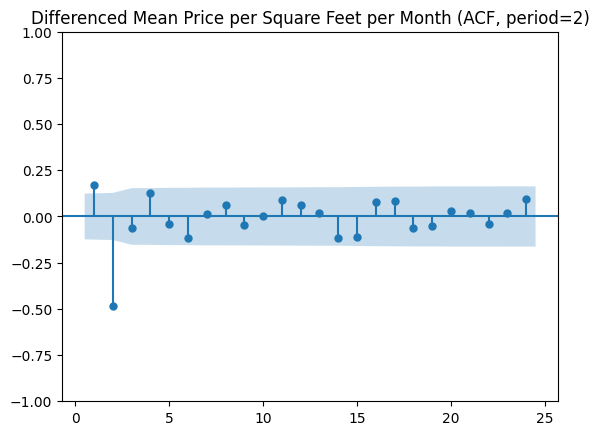

In [231]:
plot_acf(mean_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (ACF, period=2)')
plt.show()

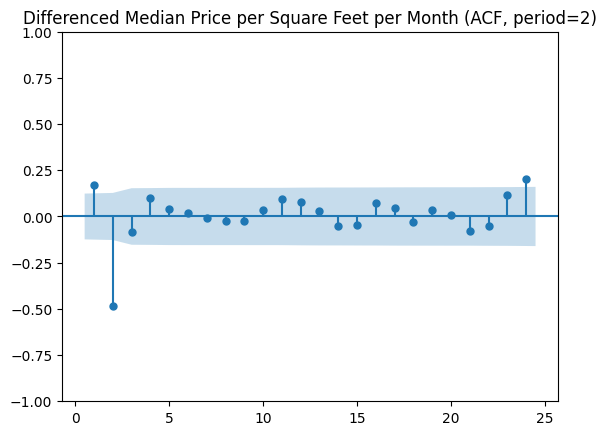

In [232]:
plot_acf(median_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (ACF, period=2)')
plt.show()

After differencing with period of 2, the ACF plot shows statistically significant coefficient up to lag 2 for mean `price_psf` and lmedian `price_psf`. This means that we can use `q=2` for ARIMA model on mean `price_psf` and median `price_psf`.

Let's do the same for PACF.

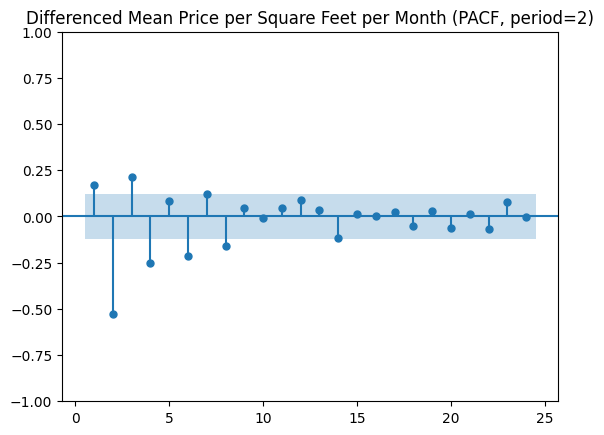

In [233]:
plot_pacf(mean_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Mean Price per Square Feet per Month (PACF, period=2)')
plt.show()

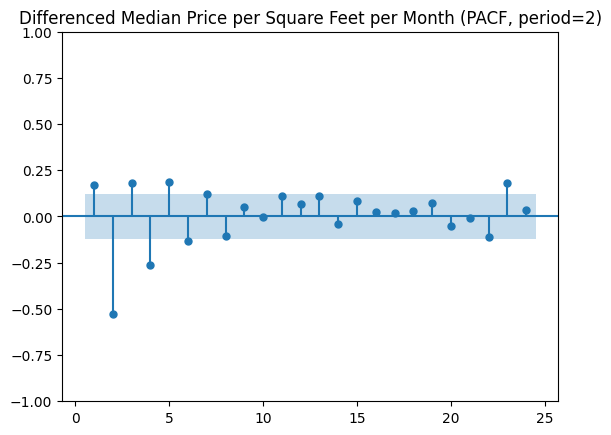

In [234]:
plot_pacf(median_monthly_price_psf_train_diff_2, zero=False)
plt.title('Differenced Median Price per Square Feet per Month (PACF, period=2)')
plt.show()

However, differenced time series shows statistically significant coefficient up to lag 4 for mean `price_psf` and lag 7 for median `price_psf`. This means that we can use `p=4` and `p=7` for ARIMA model on mean `price_psf` and median `price_psf` respectively.

For ARIMA model, we can use the following configurations:
- Mean `price_psf`: (p, d, q) = (2, 2, 4)
- Median `price_psf`: (p, d, q) = (2, 2, 7)

## Block cross validation

In [235]:
def block_cv(series: pd.Series, n_splits=5, test_sample_size=6, return_list=False):
    n = len(series)
    fold_size = int(n / n_splits)

    start = 0
    end = fold_size
    train_size = 1 - (test_sample_size / fold_size)

    for i in range(n_splits):
        split = series.iloc[start:start + fold_size]

        train = split[:int(fold_size * train_size)]
        test = split[int(fold_size * train_size):]

        if return_list:
            yield train.index.to_list(), test.index.to_list()
        else:
            yield train, test

        start += fold_size
        end += fold_size

In [236]:
def plot_cv_indices(X: pd.DataFrame, n_splits=5, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    _, ax = plt.subplots()

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(block_cv(X, n_splits=n_splits, return_list=True)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        print(f'Split {ii}: {tr}, {tt}')

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits, -0.2],
        title="Block cross validation of monthly price per square feet",
    )

    return ax

Split 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], [44, 45, 46, 47, 48, 49]
Split 1: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93], [94, 95, 96, 97, 98, 99]
Split 2: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143], [144, 145, 146, 147, 148, 149]
Split 3: [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193], [194, 195, 196, 197, 198, 199]
Split 4: [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

<Axes: title={'center': 'Block cross validation of monthly price per square feet'}, xlabel='Sample index', ylabel='CV iteration'>

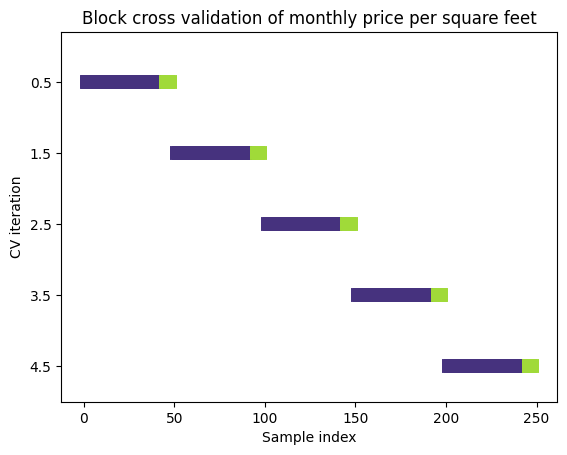

In [237]:
plot_cv_indices(mean_monthly_price_psf_train_diff_1.reset_index())

## Grid search with cross validation on mean `price_psf`
Based on the analysis with ACF and PACF plots above, we will use the following configurations for ARIMA model:
- Mean `price_psf`: (p, d, q) = (3, 1, 2), (2, 2, 4)
- Median `price_psf`: (p, d, q) = (3, 1, 1), (2, 2, 7)

We then compare the models using RMSE, AIM and BIC. The reason is due to:
- RMSE is the most popular metric for regression problems and it penalises large errors.
- AIC is a measure of the relative quality of a statistical model for a given set of data. AIC balances the goodness of fit of the model with the complexity or number of parameters in the model. A lower AIC value indicates a better balance between model fit and simplicity.
- BIC is similar to AIC but it penalises models with more parameters more severely.

In [238]:
from itertools import product

p = range(1,4)
i = range(1,3)
q = range(1,8)
orders = list(product(p, i, q))
print(f'Number of orders: {len(orders)}')

Number of orders: 42


In [239]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_gamma_deviance, mean_poisson_deviance, max_error

def evaluate_model(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    me = max_error(y_true, y_pred)
    rmsle = np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
    mpd = mean_poisson_deviance(y_true, y_pred)
    mgd = mean_gamma_deviance(y_true, y_pred)
    

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R2: {r2}")
    print(f"ME: {me}")
    print(f"RMSLE: {rmsle}")
    print(f"MPD: {mpd}")
    print(f"MGD: {mgd}")

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'me': me,
        'rmsle': rmsle,
        'mpd': mpd,
        'mgd': mgd,
    }

### ARIMA on mean `price_psf`

In [240]:
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean

mae, rmse, aic, bic = [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, val) in enumerate(block_cv(mean_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mae, fold_rmse, fold_aic, fold_bic = [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                arima = ARIMA(train, order=order, freq=train.index.inferred_freq).fit()
                arima_forecast = arima.forecast(len(val))
                fold_mae.append(mean_absolute_error(arima_forecast, val))
                fold_rmse.append(mean_squared_error(arima_forecast, val, squared=False))
                fold_aic.append(arima.aic)
                fold_bic.append(arima.bic)
            except:
                fold_mae.append(np.nan)
                fold_rmse.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    mae.append(mean(fold_mae))
    rmse.append(mean(fold_rmse))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_arima_eval = pd.DataFrame({'order': orders, 'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic})
df_arima_eval.sort_values(by=['rmse', 'aic', 'bic'], ascending=True).head(10)

 10%|▉         | 4/42 [00:00<00:08,  4.28it/s]

100%|██████████| 42/42 [00:24<00:00,  1.69it/s]


,order,mae,rmse,aic,bic
22,"(2, 2, 2)",10.933053,12.441379,1120.627258,1134.480681
7,"(1, 2, 1)",10.453818,12.644193,1117.511619,1125.823673
8,"(1, 2, 2)",23.513177,26.033292,1123.078337,1134.161076
0,"(1, 1, 1)",24.413935,28.004439,1104.255703,1112.593074
10,"(1, 2, 4)",25.363842,28.916614,1095.417826,1112.041934
23,"(2, 2, 3)",25.869246,28.987469,1100.050740,1116.674847
1,"(1, 1, 2)",27.247881,30.559925,1105.029145,1116.145639
16,"(2, 1, 3)",30.101916,36.714722,1098.227298,1114.902039
9,"(1, 2, 3)",36.663220,38.600058,1101.845647,1115.699070
24,"(2, 2, 4)",37.060343,43.303198,1091.047648,1110.442441


In [241]:
df_arima_eval[df_arima_eval['order'] == (3, 1, 2)]

,order,mae,rmse,aic,bic
29,"(3, 1, 2)",46.283082,55.993806,1095.565959,1112.2407


In [242]:
df_arima_eval[df_arima_eval['order'] == (2, 2, 4)]

,order,mae,rmse,aic,bic
24,"(2, 2, 4)",37.060343,43.303198,1091.047648,1110.442441


The best order inferred from the grid search is (2, 2, 2), which is different from the order suggested by ACF and PACF plots. However if we consider AIC and BIC as well, the best model is (1, 2, 1), as it has competitive RMSE, as well as lowest AIC and BIC.

Despite the RMSE suggesting that ARIMA(2, 2, 2) is the best model, we should visualise it to see if it really is the best model. The model will be tasked to forecast 36 months ahead, aligns with the objective of forecasting 2021-2023 with 2000-2020 data.

In [243]:
def plot_train_set_mean_forecast(model, train_data, order, forecast_length=12):
    train = train_data.iloc[:-forecast_length]
    val = train_data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__

    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')

    train_data.plot(
        kind='line',
        title=f'Mean Price per Square Feet per Month - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -859.634
Date:                Fri, 08 Dec 2023   AIC                           1731.267
Time:                        16:03:32   BIC                           1751.491
Sample:                    01-01-2000   HQIC                          1739.439
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6069      0.104     -5.863      0.000      -0.810      -0.404
ar.L2         -0.9185      0.064    -14.286      0.000      -1.045      -0.793
ar.L3         -0.4758      0.055     -8.642      0.0

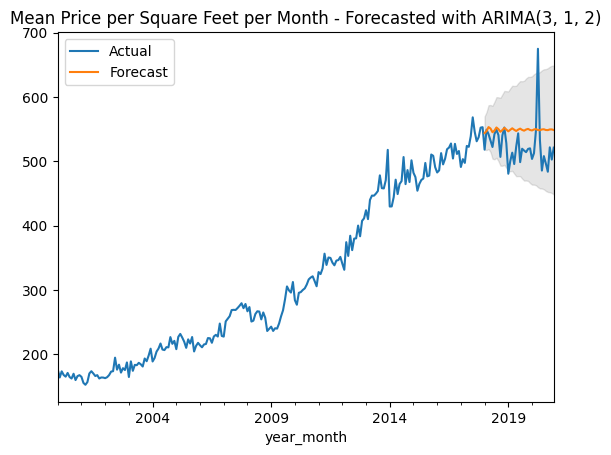

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -866.096
Date:                Fri, 08 Dec 2023   AIC                           1742.191
Time:                        16:03:32   BIC                           1759.021
Sample:                    01-01-2000   HQIC                          1748.992
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1483      0.245     -4.694      0.000      -1.628      -0.669
ar.L2         -0.2481      0.131     -1.895      0.058      -0.505       0.009
ma.L1         -0.2232      0.238     -0.940      0.3

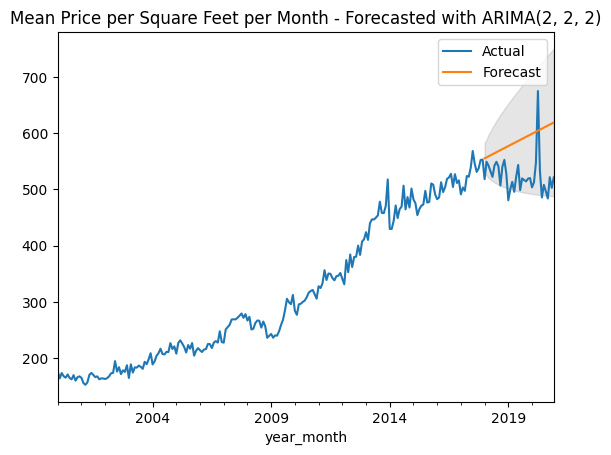

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(2, 2, 4)   Log Likelihood                -854.917
Date:                Fri, 08 Dec 2023   AIC                           1723.834
Time:                        16:03:33   BIC                           1747.396
Sample:                    01-01-2000   HQIC                          1733.355
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8063      0.042    -42.648      0.000      -1.889      -1.723
ar.L2         -0.8944      0.043    -20.962      0.000      -0.978      -0.811
ma.L1          0.3985    106.207      0.004      0.9

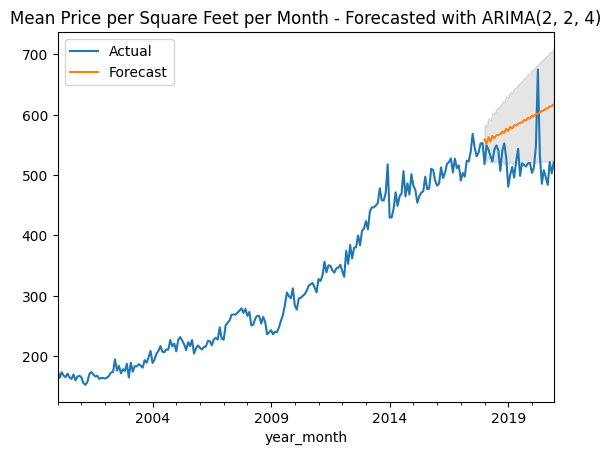

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -867.252
Date:                Fri, 08 Dec 2023   AIC                           1740.505
Time:                        16:03:33   BIC                           1750.603
Sample:                    01-01-2000   HQIC                          1744.585
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4108      0.038    -10.847      0.000      -0.485      -0.337
ma.L1         -0.9950      0.019    -51.225      0.000      -1.033      -0.957
sigma2       189.1041     12.480     15.152      0.0

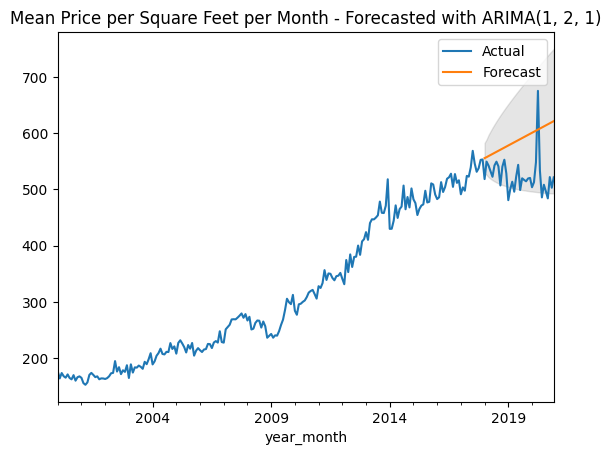

In [244]:
best_orders = [(3, 1, 2), (2, 2, 2), (2, 2, 4), (1, 2, 1)]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_mean_forecast(ARIMA, mean_monthly_price_psf_train['price_psf'], best_order, forecast_length)

- ARIMA(2, 2, 2) forecasted somewhat upward trend. However, the actual values are somewhat flat.
- ARIMA(3, 1, 2) forecasted a slightly flat trend, aligns with the actual values.
- Like ARIMA(2, 2, 2), ARIMA(1, 2, 1) forecasted somewhat upward trend.
- Similar to ARIMA(2, 2, 2), ARIMA(2, 2, 4) forecasted somewhat upward trend. However, the actual values are somewhat flat.

It seems that ARIMA(3, 1, 2) is the best model for mean `price_psf`, although ARIMA(2, 2, 2) has the least RMSE and ARIMA(1, 2, 1) has the least AIC and BIC.

### SARIMA on mean `price_psf`

In [245]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mae, rmse, aic, bic = [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, test) in enumerate(block_cv(mean_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mae, fold_rmse, fold_aic, fold_bic = [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                sarima = SARIMAX(train, order=order, freq=train.index.inferred_freq).fit()
                sarima_forecast = sarima.forecast(len(test))
                fold_mae.append(np.mean(np.abs(sarima_forecast - test)))
                fold_rmse.append(np.sqrt(np.mean((sarima_forecast - test) ** 2)))
                fold_aic.append(sarima.aic)
                fold_bic.append(sarima.bic)
            except:
                fold_mae.append(np.nan)
                fold_rmse.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)
    
    mae.append(mean(fold_mae))
    rmse.append(mean(fold_rmse))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_sarima_eval = pd.DataFrame({'order': orders, 'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic})
df_sarima_eval.sort_values(by=['rmse', 'aic', 'bic'], ascending=True).head(10)

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:22<00:00,  1.84it/s]


,order,mae,rmse,aic,bic
22,"(2, 2, 2)",10.933053,12.441379,1120.627258,1134.480681
7,"(1, 2, 1)",10.453818,12.644193,1117.511619,1125.823673
8,"(1, 2, 2)",23.513177,26.033292,1123.078337,1134.161076
0,"(1, 1, 1)",24.413935,28.004439,1104.255703,1112.593074
10,"(1, 2, 4)",25.363842,28.916614,1095.417826,1112.041934
23,"(2, 2, 3)",25.869246,28.987469,1100.050740,1116.674847
1,"(1, 1, 2)",27.247881,30.559925,1105.029145,1116.145639
16,"(2, 1, 3)",30.101916,36.714722,1098.227298,1114.902039
9,"(1, 2, 3)",36.663220,38.600058,1101.845647,1115.699070
24,"(2, 2, 4)",37.060343,43.303198,1091.047648,1110.442441


In [246]:
df_sarima_eval[df_sarima_eval['order'] == (3, 1, 2)]

,order,mae,rmse,aic,bic
29,"(3, 1, 2)",46.283082,55.993806,1095.565959,1112.2407


In [247]:
df_sarima_eval[df_sarima_eval['order'] == (2, 2, 4)]

,order,mae,rmse,aic,bic
24,"(2, 2, 4)",37.060343,43.303198,1091.047648,1110.442441


The best order inferred from the grid search is (2, 2, 2), which is different from the order suggested by ACF and PACF plots. However if we consider AIC and BIC as well, the best model is (1, 2, 1), as it has competitive RMSE, as well as lowest AIC and BIC. This is similar to ARIMA.

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -859.634
Date:                Fri, 08 Dec 2023   AIC                           1731.267
Time:                        16:03:57   BIC                           1751.491
Sample:                    01-01-2000   HQIC                          1739.439
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6069      0.104     -5.863      0.000      -0.810      -0.404
ar.L2         -0.9185      0.064    -14.286      0.000      -1.045      -0.793
ar.L3         -0.4758      0.055     -8.642      0.0

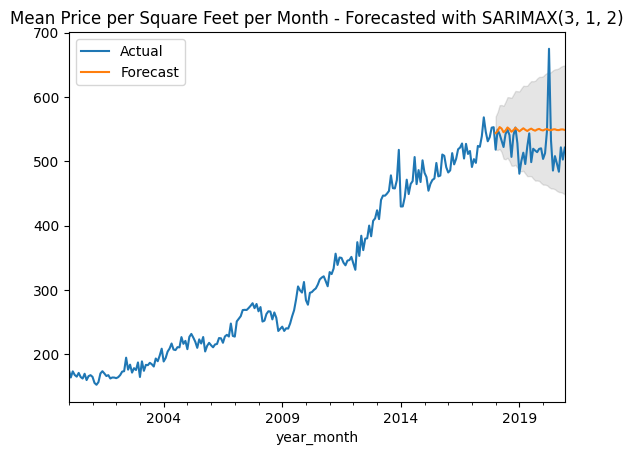

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -866.096
Date:                Fri, 08 Dec 2023   AIC                           1742.191
Time:                        16:03:57   BIC                           1759.021
Sample:                    01-01-2000   HQIC                          1748.992
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1483      0.245     -4.694      0.000      -1.628      -0.669
ar.L2         -0.2481      0.131     -1.895      0.058      -0.505       0.009
ma.L1         -0.2232      0.238     -0.940      0.3

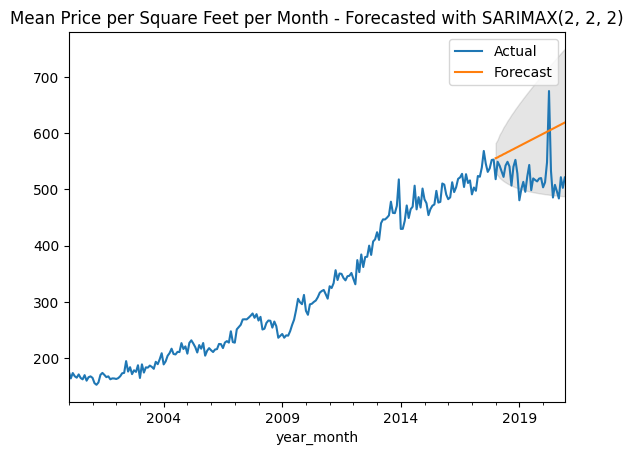

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(2, 2, 4)   Log Likelihood                -854.917
Date:                Fri, 08 Dec 2023   AIC                           1723.834
Time:                        16:03:58   BIC                           1747.396
Sample:                    01-01-2000   HQIC                          1733.355
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8063      0.042    -42.648      0.000      -1.889      -1.723
ar.L2         -0.8944      0.043    -20.962      0.000      -0.978      -0.811
ma.L1          0.3985    106.207      0.004      0.9

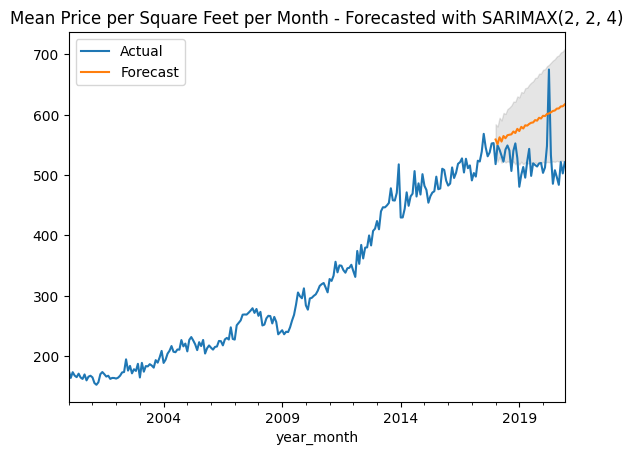

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -867.252
Date:                Fri, 08 Dec 2023   AIC                           1740.505
Time:                        16:03:58   BIC                           1750.603
Sample:                    01-01-2000   HQIC                          1744.585
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4108      0.038    -10.847      0.000      -0.485      -0.337
ma.L1         -0.9950      0.019    -51.225      0.000      -1.033      -0.957
sigma2       189.1041     12.480     15.152      0.0

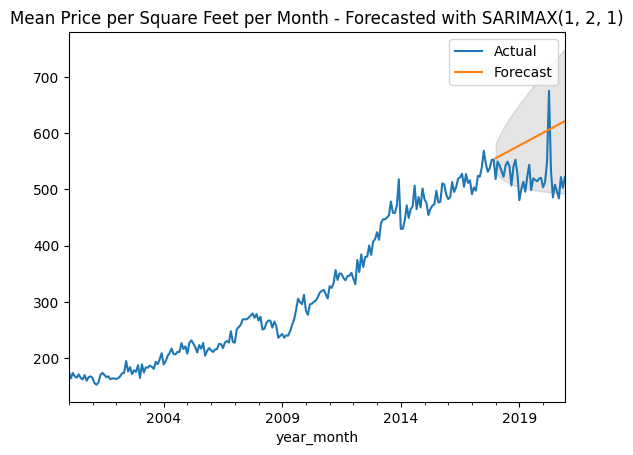

In [248]:
best_orders = [(3, 1, 2), (2, 2, 2), (2, 2, 4), (1, 2, 1)]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_mean_forecast(SARIMAX, mean_monthly_price_psf_train['price_psf'], best_order, forecast_length)

From the plots above, similar to ARIMA, SARIMA(3, 1, 2) is the best model.

### Holt's exponential smoothing on mean `price_psf`

In [249]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

mae, rmse, aic, bic = [], [], [], []
periods = range(1,13)
for period in tqdm(periods, total=len(periods)):
    for fold, (train, test) in enumerate(block_cv(mean_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mae, fold_rmse, fold_aic, fold_bic = [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                holtwinters = ETSModel(
                    train, 
                    error='add', 
                    trend='mul', 
                    seasonal='mul', 
                    freq=train.index.inferred_freq, 
                    seasonal_periods=period, 
                    damped_trend=True
                ).fit()
                holtwinters_forecast = holtwinters.forecast(len(test))
                fold_mae.append(mean_absolute_error(holtwinters_forecast, test))
                fold_rmse.append(mean_squared_error(holtwinters_forecast, test, squared=False))
                fold_aic.append(holtwinters.aic)
                fold_bic.append(holtwinters.bic)
            except:
                fold_mae.append(np.nan)
                fold_rmse.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    mae.append(mean(fold_mae))
    rmse.append(mean(fold_rmse))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_holtwinters_eval = pd.DataFrame({'periods': periods, 'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic})
df_holtwinters_eval.sort_values(by=['rmse', 'aic', 'bic'], ascending=True)

100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


,periods,mae,rmse,aic,bic
10,11,25.471040,29.580173,1117.325874,1167.500725
8,9,30.504550,33.752976,1122.030258,1166.630126
5,6,32.788255,34.190336,1118.182723,1154.420115
1,2,34.003387,35.891869,1113.516007,1138.603433
9,10,33.792005,36.089794,1124.092098,1171.479458
2,3,34.521448,36.695340,1117.758500,1145.633417
6,7,35.162152,37.607649,1119.604801,1158.629685
4,5,34.736503,38.027191,1120.011323,1153.461224
3,4,38.057298,40.060108,1104.802267,1135.464676
7,8,38.668151,40.104592,1111.965362,1153.777738


Holt-Winter's exponential smoothing has lowest MAE and RMSE when period is 11.

                                 ETS Results                                  
Dep. Variable:              price_psf   No. Observations:                  216
Model:                      ETS(AMdM)   Log Likelihood                -846.484
Date:                Fri, 08 Dec 2023   AIC                           1730.967
Time:                        16:04:00   BIC                           1795.098
Sample:                    01-01-2000   HQIC                          1756.876
                         - 12-01-2017   Scale                          148.404
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4803      0.049      9.894      0.000       0.385       0.575
smoothing_trend         0.0166        nan        nan        nan         nan         nan
smoothing_season

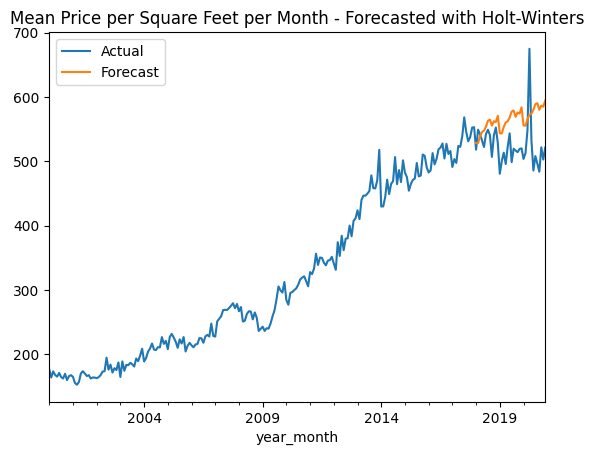

In [250]:
best_period = 11
forecast_length = 36

train = mean_monthly_price_psf_train['price_psf'].iloc[:-forecast_length]
val = mean_monthly_price_psf_train['price_psf'].iloc[-forecast_length:]

holtwinters = ETSModel(
    train, 
    error='add', 
    trend='mul', 
    seasonal='mul', 
    freq=train.index.inferred_freq, 
    seasonal_periods=period, 
    damped_trend=True
).fit()
holtwinters_forecast = holtwinters.forecast(forecast_length)
print(holtwinters.summary())
print(f'RMSE: {mean_squared_error(val, holtwinters_forecast, squared=False)}')

mean_monthly_price_psf_train.plot(
    kind='line',
    title='Mean Price per Square Feet per Month - Forecasted with Holt-Winters',
)
holtwinters_forecast.plot(
    kind='line',
)
plt.legend(['Actual', 'Forecast'])
plt.show()

Unfortunately `ETSModel` does not support prediction intervals like `ARIMA` and `SARIMAX`. However, the best model for Holt-Winters has higher RMSE than best model of ARIMA/SARIMAX.

Let's evaluate on test set.

## Evaluate models on mean `price_psf` test set

Length of grouped dataframe: 30


C:\Users\USER\AppData\Local\Temp\ipykernel_6396\619011678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_price_psf_test['year_month'] = pd.to_datetime(df_monthly_price_psf_test[['year', 'month']].assign(day=1))


<Axes: title={'center': 'Mean and Median Price per Square Feet per Month (2020-2023)'}, xlabel='year_month'>

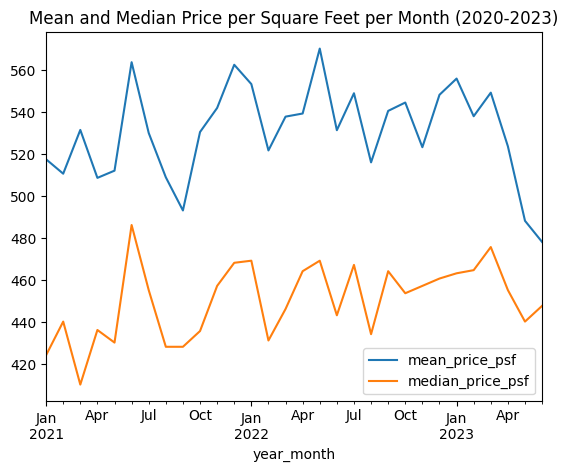

In [251]:
df_monthly_price_psf_test = df_test[['year', 'month', 'price_psf']]
df_monthly_price_psf_test['year_month'] = pd.to_datetime(df_monthly_price_psf_test[['year', 'month']].assign(day=1))

mean_monthly_price_psf_test = df_monthly_price_psf_test[['year_month', 'price_psf']].groupby('year_month').mean()
median_monthly_price_psf_test = df_monthly_price_psf_test[['year_month', 'price_psf']].groupby('year_month').median()

df_price_psf_per_month_test = pd.concat([mean_monthly_price_psf_test, median_monthly_price_psf_test], axis=1)
df_price_psf_per_month_test.columns = ['mean_price_psf', 'median_price_psf']

print(f'Length of grouped dataframe: {len(df_price_psf_per_month_test)}')

df_price_psf_per_month_test.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (2020-2023)',
)

<Axes: title={'center': 'Mean and Median Price per Square Feet per Month (2000-2023)'}, xlabel='year_month'>

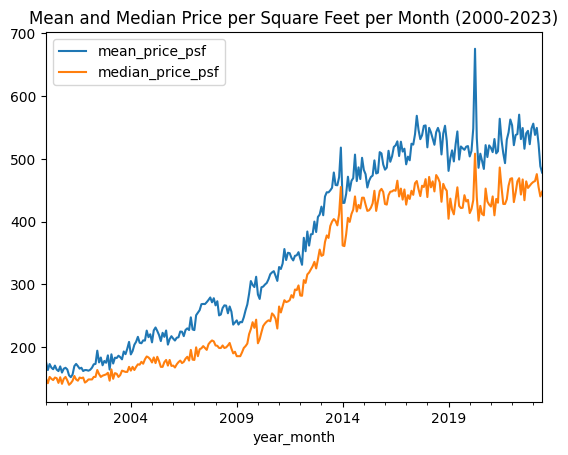

In [252]:
df_monthly_price_psf = pd.concat([df_price_psf_per_month_train, df_price_psf_per_month_test], axis=0)
monthly_price_psf = df_monthly_price_psf[['mean_price_psf', 'median_price_psf']]
monthly_price_psf.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month (2000-2023)',
)

In [253]:
def plot_arma_mean_forecast(model, data, order, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__
    
    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    if verbose:
        print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')
    result = evaluate_model(val, forecast)

    data.plot(
        kind='line',
        title=f'Mean Price per Square Feet per Month (2000-2023) - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'{model_name} {str(order)}',
        **result,
    }

RMSE with ARIMA(3, 1, 2): 28.67042135920696
MSE: 821.9930609144707
RMSE: 28.67042135920696
MAE: 24.508723341774363
MAPE: 0.045499770896001795
R2: -0.6822910554766948
ME: 58.66920511558061
RMSLE: 0.05413015586882549
MPD: 1.5706344894067266
MGD: 0.0030027865552070634


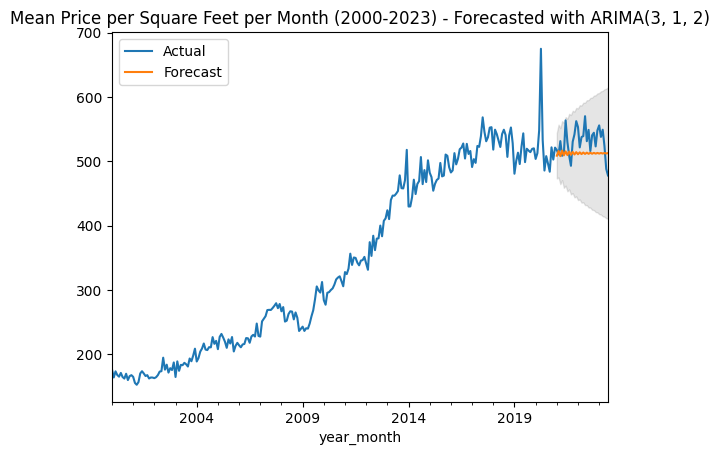

RMSE with ARIMA(2, 2, 2): 25.96724485910189
MSE: 674.2978055725536
RMSE: 25.96724485910189
MAE: 18.601215220846036
MAPE: 0.03586044842887329
R2: -0.38001793565055664
ME: 81.24883171017615
RMSLE: 0.04927236076539473
MPD: 1.2646976420181772
MGD: 0.0023742058413505815


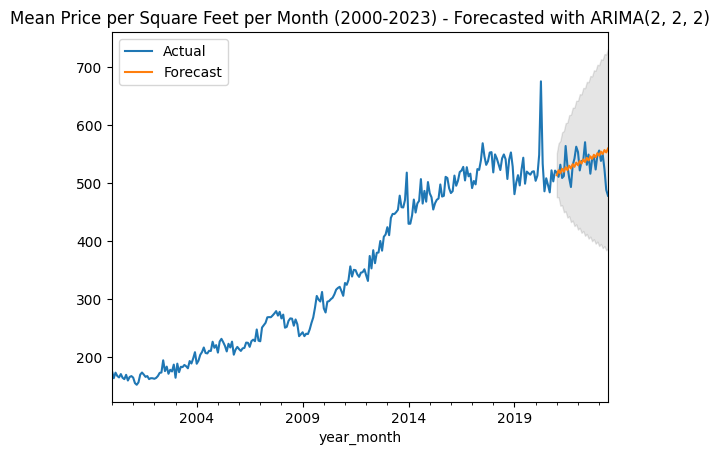

RMSE with ARIMA(2, 2, 4): 25.282463069008642
MSE: 639.202938835786
RMSE: 25.282463069008642
MAE: 17.587086704941257
MAPE: 0.03385758333147007
R2: -0.30819277895309183
ME: 76.60370681969977
RMSLE: 0.04802912822035034
MPD: 1.2023495230154366
MGD: 0.002263575589623083


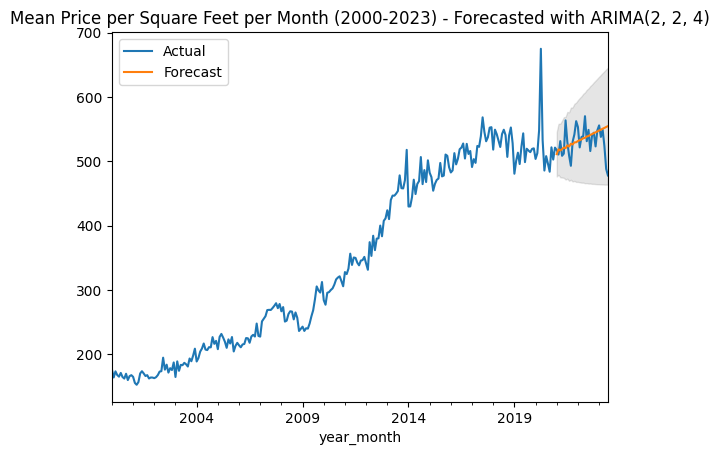

RMSE with ARIMA(1, 2, 1): 25.95401118056924
MSE: 673.6106963611131
RMSE: 25.95401118056924
MAE: 17.714811925556326
MAPE: 0.034263380323902456
R2: -0.37861169789076854
ME: 80.28944324637376
RMSLE: 0.049272383100670274
MPD: 1.2627420746889129
MGD: 0.0023693286104518483


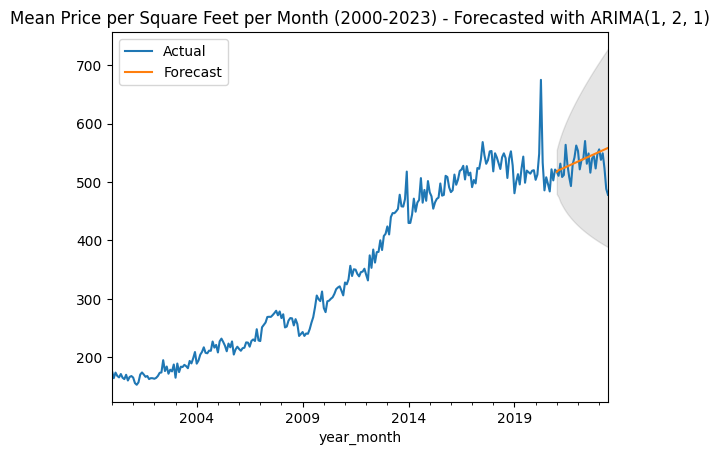

In [254]:
best_orders = [(3, 1, 2), (2, 2, 2), (2, 2, 4), (1, 2, 1)]
forecast_length = 30
arima_test_results = []

mean_monthly_price_psf = monthly_price_psf['mean_price_psf']

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_mean_forecast(ARIMA, mean_monthly_price_psf, best_order, forecast_length)
        arima_test_results.append(result)

RMSE with SARIMAX(3, 1, 2): 28.67042135920696
MSE: 821.9930609144707
RMSE: 28.67042135920696
MAE: 24.508723341774363
MAPE: 0.045499770896001795
R2: -0.6822910554766948
ME: 58.66920511558061
RMSLE: 0.05413015586882549
MPD: 1.5706344894067266
MGD: 0.0030027865552070634


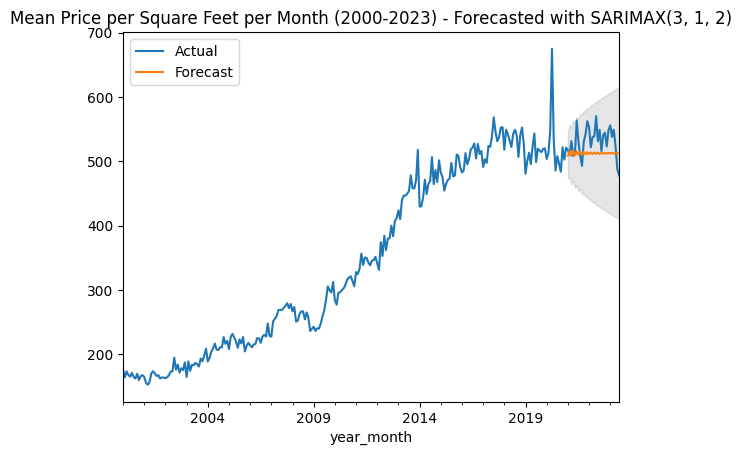

RMSE with SARIMAX(2, 2, 2): 25.96724485910189
MSE: 674.2978055725536
RMSE: 25.96724485910189
MAE: 18.601215220846036
MAPE: 0.03586044842887329
R2: -0.38001793565055664
ME: 81.24883171017615
RMSLE: 0.04927236076539473
MPD: 1.2646976420181772
MGD: 0.0023742058413505815


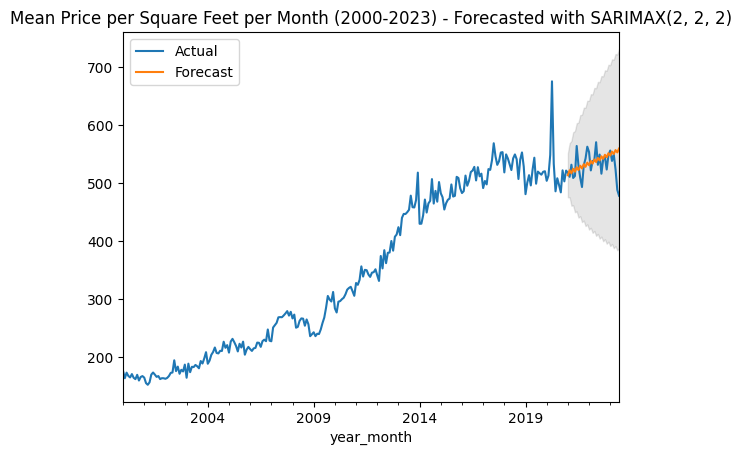

RMSE with SARIMAX(2, 2, 4): 25.282463069008642
MSE: 639.202938835786
RMSE: 25.282463069008642
MAE: 17.587086704941257
MAPE: 0.03385758333147007
R2: -0.30819277895309183
ME: 76.60370681969977
RMSLE: 0.04802912822035034
MPD: 1.2023495230154366
MGD: 0.002263575589623083


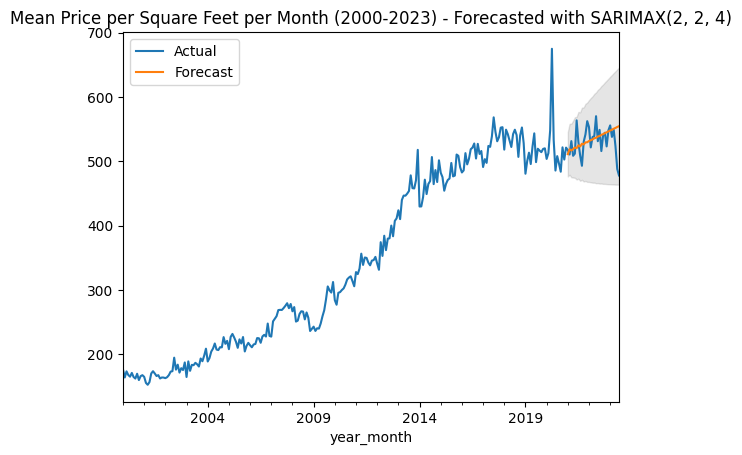

RMSE with SARIMAX(1, 2, 1): 25.95401118056924
MSE: 673.6106963611131
RMSE: 25.95401118056924
MAE: 17.714811925556326
MAPE: 0.034263380323902456
R2: -0.37861169789076854
ME: 80.28944324637376
RMSLE: 0.049272383100670274
MPD: 1.2627420746889129
MGD: 0.0023693286104518483


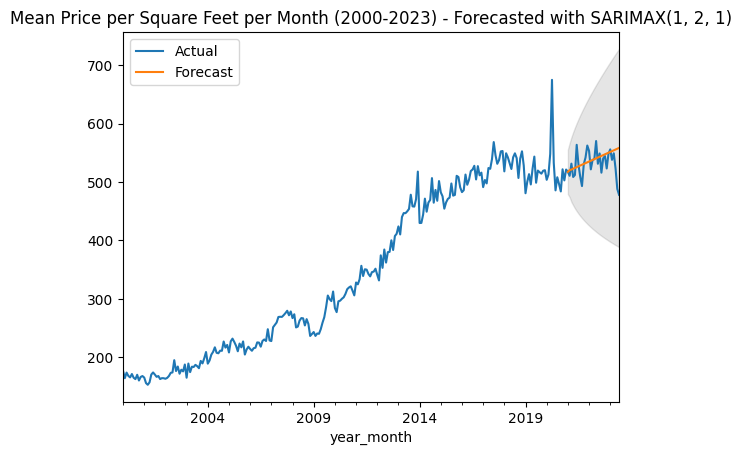

In [255]:
sarima_test_results = []

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_mean_forecast(SARIMAX, mean_monthly_price_psf, best_order, forecast_length)
        sarima_test_results.append(result)

When evaluating on test set, it seems SARIMAX(2, 2, 4) has the lowest RMSE. SARIMAX(2, 2, 4) will be chosen as the best model.

In [256]:
def plot_holtwinters_mean_forecast(data, period, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    holtwinters = ETSModel(
        train, 
        error='add', 
        trend='mul', 
        seasonal='mul', 
        freq=train.index.inferred_freq, 
        seasonal_periods=period, 
        damped_trend=True
    ).fit()
    holtwinters_forecast = holtwinters.forecast(forecast_length)
    if verbose:
        print(holtwinters.summary())
    print(f'RMSE: {mean_squared_error(val, holtwinters_forecast, squared=False)}')
    result = evaluate_model(val, holtwinters_forecast)

    data.plot(
        kind='line',
        title='Mean Price per Square Feet per Month (2000-2023) - Forecasted with Holt-Winters',
    )
    holtwinters_forecast.plot(
        kind='line',
    )
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'Holt-Winters (p={period})',
        **result,
    }

RMSE: 26.783330703368865
MSE: 717.3468035660213
RMSE: 26.783330703368865
MAE: 21.85345357083955
MAPE: 0.04067794409124053
R2: -0.46812201792964125
ME: 59.76154383368828
RMSLE: 0.05055865498764959
MPD: 1.3689293155895106
MGD: 0.002613959151235701


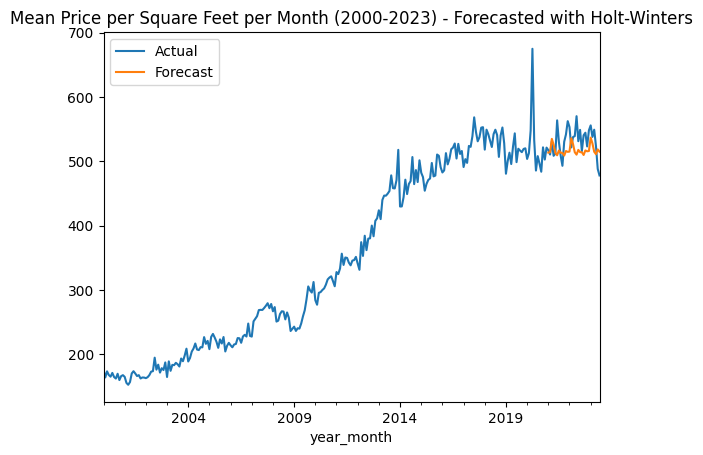

In [257]:
best_period = 11
holtwinters_test_results = []

result = plot_holtwinters_mean_forecast(mean_monthly_price_psf, best_period, forecast_length)
holtwinters_test_results.append(result)

## Statistical evaluation on mean `price_psf` test set
We will employ three statistical tests to evaluate the performance of the models:
1. Friedman test
2. Iman-Davenport test
3. Nemenyi post-hoc test

These can be performed via the following steps as outlined in Zhan et al. (2023):
1. Ranking the performance of each algorithm according to different evaluation measures to obtain an average ranking for each algorithm;
2. Using Friedman and Iman–Davenport to test whether the algorithms all perform equally; 
3. Utilizing the Nemenyi post-hoc test to further distinguish between the algorithms.

In [258]:
mean_price_psf_test_results = arima_test_results + sarima_test_results + holtwinters_test_results

df_mean_price_psf_test_results = pd.DataFrame(mean_price_psf_test_results)
df_mean_price_psf_test_results

,model,mse,rmse,...,rmsle,mpd,mgd
0,"ARIMA (3, 1, 2)",821.993061,28.670421,...,0.054130,1.570634,0.003003
1,"ARIMA (2, 2, 2)",674.297806,25.967245,...,0.049272,1.264698,0.002374
2,"ARIMA (2, 2, 4)",639.202939,25.282463,...,0.048029,1.202350,0.002264
3,"ARIMA (1, 2, 1)",673.610696,25.954011,...,0.049272,1.262742,0.002369
4,"SARIMAX (3, 1, 2)",821.993061,28.670421,...,0.054130,1.570634,0.003003
5,"SARIMAX (2, 2, 2)",674.297806,25.967245,...,0.049272,1.264698,0.002374
6,"SARIMAX (2, 2, 4)",639.202939,25.282463,...,0.048029,1.202350,0.002264
7,"SARIMAX (1, 2, 1)",673.610696,25.954011,...,0.049272,1.262742,0.002369
8,Holt-Winters (p=11),717.346804,26.783331,...,0.050559,1.368929,0.002614


### Assign rank to each model based on each evaluation metric

In [277]:
metrics = ['mse', 'mae', 'rmse', 'mape', 'r2', 'me', 'rmsle', 'mpd', 'mgd']

for metric in metrics:
    df_mean_price_psf_test_results['rank_' + metric] = df_mean_price_psf_test_results[metric].rank()

df_mean_price_psf_test_results

,model,mse,rmse,...,rank_mpd,rank_mgd,mean_rank
0,"ARIMA (3, 1, 2)",821.993061,28.670421,...,8.5,8.5,6.944444
1,"ARIMA (2, 2, 2)",674.297806,25.967245,...,5.5,5.5,5.500000
2,"ARIMA (2, 2, 4)",639.202939,25.282463,...,1.5,1.5,2.611111
3,"ARIMA (1, 2, 1)",673.610696,25.954011,...,3.5,3.5,4.388889
4,"SARIMAX (3, 1, 2)",821.993061,28.670421,...,8.5,8.5,6.944444
5,"SARIMAX (2, 2, 2)",674.297806,25.967245,...,5.5,5.5,5.500000
6,"SARIMAX (2, 2, 4)",639.202939,25.282463,...,1.5,1.5,2.611111
7,"SARIMAX (1, 2, 1)",673.610696,25.954011,...,3.5,3.5,4.388889
8,Holt-Winters (p=11),717.346804,26.783331,...,7.0,7.0,6.111111


In [278]:
df_mean_price_psf_test_results['mean_rank'] = df_mean_price_psf_test_results[[col for col in df_mean_price_psf_test_results.columns if 'rank' in col]].mean(axis=1)
df_mean_price_psf_test_results

,model,mse,rmse,...,rank_mpd,rank_mgd,mean_rank
0,"ARIMA (3, 1, 2)",821.993061,28.670421,...,8.5,8.5,6.944444
1,"ARIMA (2, 2, 2)",674.297806,25.967245,...,5.5,5.5,5.500000
2,"ARIMA (2, 2, 4)",639.202939,25.282463,...,1.5,1.5,2.611111
3,"ARIMA (1, 2, 1)",673.610696,25.954011,...,3.5,3.5,4.388889
4,"SARIMAX (3, 1, 2)",821.993061,28.670421,...,8.5,8.5,6.944444
5,"SARIMAX (2, 2, 2)",674.297806,25.967245,...,5.5,5.5,5.500000
6,"SARIMAX (2, 2, 4)",639.202939,25.282463,...,1.5,1.5,2.611111
7,"SARIMAX (1, 2, 1)",673.610696,25.954011,...,3.5,3.5,4.388889
8,Holt-Winters (p=11),717.346804,26.783331,...,7.0,7.0,6.111111


### Friedman test

H0: All models perform equally well.

H1: At least one model performs differently.

In [279]:
number_of_models = len(df_mean_price_psf_test_results)
number_of_metrics = len(metrics)

t_chi_square = 12 * number_of_metrics / (number_of_metrics * (number_of_metrics + 1)) * \
    sum((df_mean_price_psf_test_results['mean_rank'] - ((number_of_models * + 1) / 2)) ** 2)
print(f'Degrees of freedom (k-1): {number_of_models - 1}')
print(f't_chi_square: {t_chi_square}')

Degrees of freedom (k-1): 8
t_chi_square: 28.448148148148153


In [280]:
from scipy.stats import friedmanchisquare

friedmanchisquare(*df_mean_price_psf_test_results[metrics].values)

FriedmanchisquareResult(statistic=26.636015325670527, pvalue=0.0008168835354436103)

With DOF = 8 at alpha = 0.05, the critical value is 15.51 (see [link](ttps://people.smp.uq.edu.au/YoniNazarathy/stat_models_B_course_spring_07/distributions/chisqtab.pdf)).

Since the computed statistic is more than the critical value, we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

### Iman-Davenport test

H0: All models perform equally well.

H1: At least one model performs differently.

In [281]:
t_chi_square = 46.26
d = 5
k = 9

(d - 1) * t_chi_square / (d * (k - 1) - t_chi_square)

-29.559105431309913

In [282]:
t_F = (number_of_metrics - 1) * t_chi_square / (number_of_metrics * (number_of_models - 1) - t_chi_square)
print(f'Degrees of freedom 1 (d-1): {number_of_metrics - 1}')
print(f'Degrees of freedom 2 (d-1)(k-1): {(number_of_metrics - 1) * (number_of_models - 1)}')
print(f't_F: {t_F}')

Degrees of freedom 1 (d-1): 8
Degrees of freedom 2 (d-1)(k-1): 64
t_F: 14.377622377622377


With DOF1 = 4 and DOF2 = 32 at alpha = 0.05, the critical value is 2.668 (see [link](https://www.stat.purdue.edu/~lfindsen/stat503/F_alpha_05.pdf)).

Since the computed statistic is less than the critical value, we fail to reject the null hypothesis H0 and conclude that there is no statistically significant difference in the performance of all algorithms.

However, the Iman-Davenport test is only useful when 𝑑 becomes larger, as 𝑇𝜒2 will gradually be biased towards chi-square random variables with degrees of freedom 𝑘 − 1. However we only have d = 5 hence we will drop this.

### Nemenyi post-hoc test

We can conduct the Nemenyi post-hoc test to find exactly which groups have different means.

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

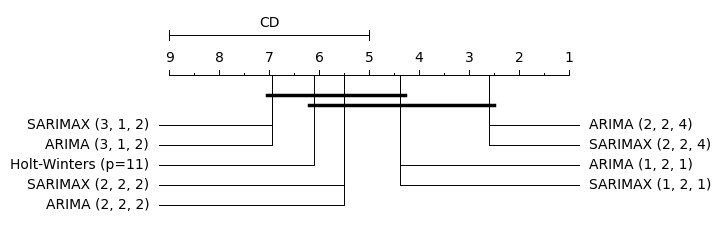

In [283]:
from autorank import autorank, plot_stats

result = autorank(df_mean_price_psf_test_results[metrics].T.rename(columns=df_mean_price_psf_test_results['model']).reset_index(drop=True), alpha=0.05, verbose=False, order='ascending')
plot_stats(result, allow_insignificant=True)
plt.show()

At alpha = 0.05, there seem to be no statistically significant difference in means between the models.

## Grid search with cross validation on median `price_psf`
Based on the analysis with ACF and PACF plots above, we will use the following configurations for ARIMA and SARIMA model:
- Mean `price_psf`: (p, d, q) = (3, 1, 2), (2, 2, 4)
- Median `price_psf`: (p, d, q) = (3, 1, 1), (2, 2, 7)

Similar to median `price_psf`, we then compare the models using RMSE, AIM and BIC.

In [284]:
from itertools import product

p = range(1,4)
i = range(1,3)
q = range(1,8)
orders = list(product(p, i, q))
print(f'Number of orders: {len(orders)}')

Number of orders: 42


### ARIMA on median `price_psf`

In [285]:
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean
mae, rmse, aic, bic = [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, val) in enumerate(block_cv(median_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mae, fold_rmse, fold_aic, fold_bic = [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                arima = ARIMA(train, order=order, freq=train.index.inferred_freq).fit()
                arima_forecast = arima.forecast(len(val))
                fold_mae.append(np.mean(np.abs(arima_forecast - val)))
                fold_rmse.append(np.sqrt(np.mean((arima_forecast - val) ** 2)))
                fold_aic.append(arima.aic)
                fold_bic.append(arima.bic)
            except:
                fold_mae.append(np.nan)
                fold_rmse.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    mae.append(mean(fold_mae))
    rmse.append(mean(fold_rmse))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_arima_eval = pd.DataFrame({'order': orders, 'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic})
df_arima_eval.sort_values(by=['rmse', 'aic', 'bic'], ascending=True).head(10)

100%|██████████| 42/42 [00:23<00:00,  1.80it/s]


,order,mae,rmse,aic,bic
15,"(2, 1, 2)",12.515858,13.986138,1032.344450,1046.240068
0,"(1, 1, 1)",10.667647,14.103324,1035.032863,1043.370234
1,"(1, 1, 2)",11.021327,14.364104,1036.609841,1047.726335
9,"(1, 2, 3)",12.458335,14.615825,1026.123463,1039.976886
16,"(2, 1, 3)",13.458697,14.887727,1029.074795,1045.749536
23,"(2, 2, 3)",12.931340,14.911701,1020.672331,1037.296438
2,"(1, 1, 3)",13.838571,14.985890,1028.030145,1041.925763
21,"(2, 2, 1)",12.703918,15.136642,1036.918225,1048.000964
17,"(2, 1, 4)",14.169166,15.493261,1021.487021,1040.940886
24,"(2, 2, 4)",13.957732,15.506647,1017.160845,1036.555637


In [286]:
df_arima_eval[df_arima_eval['order'] == (3, 1, 1)]

,order,mae,rmse,aic,bic
28,"(3, 1, 1)",19.584806,24.681254,1021.387193,1035.28281


In [287]:
df_arima_eval[df_arima_eval['order'] == (2, 2, 7)]

,order,mae,rmse,aic,bic
27,"(2, 2, 7)",17.967582,22.300317,1018.178704,1045.885551


The best order inferred from the grid search is (2, 1, 2), which is different from the order suggested by ACF and PACF plots.

Despite the RMSE suggesting that ARIMA(2, 1, 2) is the best model, we should visualise it to see if it really is the best model. The model will be tasked to forecast 36 months ahead, aligns with the objective of forecasting 2021-2023 with 2000-2020 data.

In [288]:
def plot_train_set_median_forecast(model, train_data, order, forecast_length=12):
    train = train_data.iloc[:-forecast_length]
    val = train_data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__

    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')

    train_data.plot(
        kind='line',
        title=f'Median Price per Square Feet per Month - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -826.246
Date:                Fri, 08 Dec 2023   AIC                           1662.492
Time:                        16:10:41   BIC                           1679.345
Sample:                    01-01-2000   HQIC                          1669.301
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8593      0.233     -3.692      0.000      -1.315      -0.403
ar.L2         -0.3840      0.112     -3.422      0.001      -0.604      -0.164
ar.L3         -0.2512      0.063     -3.983      0.0

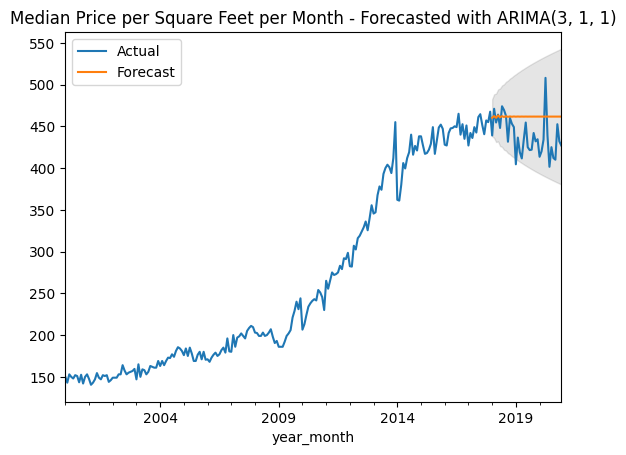

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -828.664
Date:                Fri, 08 Dec 2023   AIC                           1667.327
Time:                        16:10:41   BIC                           1684.180
Sample:                    01-01-2000   HQIC                          1674.137
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7113      0.300     -2.372      0.018      -1.299      -0.123
ar.L2          0.1564      0.142      1.104      0.270      -0.121       0.434
ma.L1          0.3308      0.297      1.113      0.2

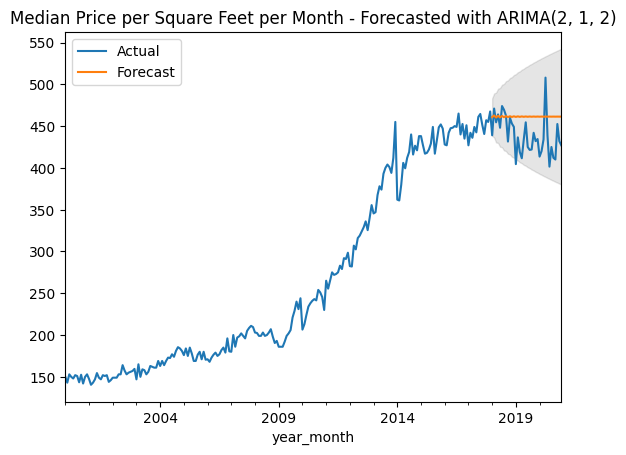

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(2, 2, 7)   Log Likelihood                -818.030
Date:                Fri, 08 Dec 2023   AIC                           1656.060
Time:                        16:10:42   BIC                           1689.720
Sample:                    01-01-2000   HQIC                          1669.662
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2973      1.024     -0.290      0.771      -2.304       1.709
ar.L2          0.4184      0.709      0.590      0.555      -0.972       1.809
ma.L1         -1.1341      1.030     -1.101      0.2

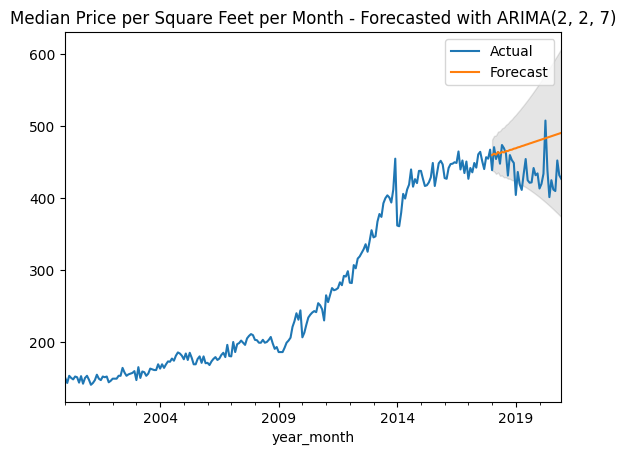

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -829.715
Date:                Fri, 08 Dec 2023   AIC                           1665.430
Time:                        16:10:42   BIC                           1675.542
Sample:                    01-01-2000   HQIC                          1669.515
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0718      0.122      0.588      0.557      -0.168       0.311
ma.L1         -0.4564      0.121     -3.759      0.000      -0.694      -0.218
sigma2       131.5780      7.574     17.372      0.0

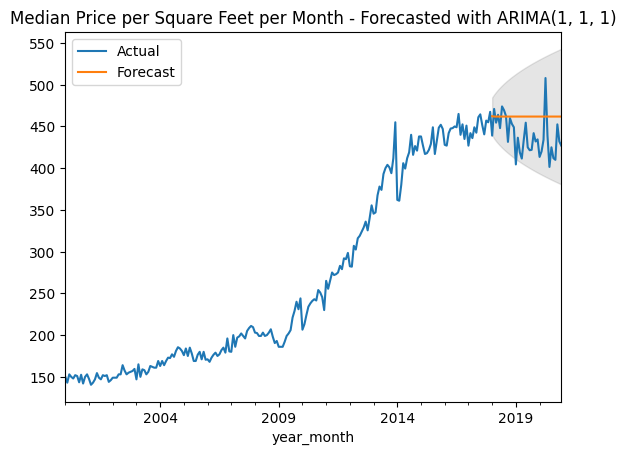

In [289]:
best_orders = [(3, 1, 1), (2, 1, 2), (2, 2, 7), (1, 1, 1)]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_median_forecast(ARIMA, median_monthly_price_psf_train['price_psf'], best_order, forecast_length)

- ARIMA(2, 1, 2), ARIMA(3, 1, 1) and ARIMA(1, 2, 1) forecasted a slightly flat trend, aligns with the actual values.
- ARIMA(2, 2, 7) forecasted somewhat upward trend. However, the actual values are somewhat flat.

It seems that ARIMA(2, 1, 2) is the best model for median `price_psf``, followed by ARIMA(3, 1, 1).

### SARIMA on mean `price_psf`

In [290]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mae, rmse, aic, bic = [], [], [], []

for order in tqdm(orders, total=len(orders)):
    for fold, (train, test) in enumerate(block_cv(median_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mae, fold_rmse, fold_aic, fold_bic = [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                sarima = SARIMAX(train, order=order, freq=train.index.inferred_freq).fit()
                sarima_forecast = sarima.forecast(len(test))
                fold_mae.append(np.mean(np.abs(sarima_forecast - test)))
                fold_rmse.append(np.sqrt(np.mean((sarima_forecast - test) ** 2)))
                fold_aic.append(sarima.aic)
                fold_bic.append(sarima.bic)
            except:
                fold_mae.append(np.nan)
                fold_rmse.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)
    
    mae.append(mean(fold_mae))
    rmse.append(mean(fold_rmse))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_sarima_eval = pd.DataFrame({'order': orders, 'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic})
df_sarima_eval.sort_values(by=['rmse', 'aic', 'bic'], ascending=True).head(10)

100%|██████████| 42/42 [00:22<00:00,  1.87it/s]


,order,mae,rmse,aic,bic
15,"(2, 1, 2)",12.515858,13.986138,1032.344450,1046.240068
0,"(1, 1, 1)",10.667647,14.103324,1035.032863,1043.370234
1,"(1, 1, 2)",11.021327,14.364104,1036.609841,1047.726335
9,"(1, 2, 3)",12.458335,14.615825,1026.123463,1039.976886
16,"(2, 1, 3)",13.458697,14.887727,1029.074795,1045.749536
23,"(2, 2, 3)",12.931340,14.911701,1020.672331,1037.296438
2,"(1, 1, 3)",13.838571,14.985890,1028.030145,1041.925763
21,"(2, 2, 1)",12.703918,15.136642,1036.918225,1048.000964
17,"(2, 1, 4)",14.169166,15.493261,1021.487021,1040.940886
24,"(2, 2, 4)",13.957732,15.506647,1017.160845,1036.555637


In [291]:
df_sarima_eval[df_sarima_eval['order'] == (3, 1, 1)]

,order,mae,rmse,aic,bic
28,"(3, 1, 1)",19.584806,24.681254,1021.387193,1035.28281


In [292]:
df_sarima_eval[df_sarima_eval['order'] == (2, 2, 7)]

,order,mae,rmse,aic,bic
27,"(2, 2, 7)",17.967582,22.300317,1018.178704,1045.885551


The best order inferred from the grid search is (2, 1, 2), which is different from the order suggested by ACF and PACF plots. This is similar to ARIMA.

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -826.246
Date:                Fri, 08 Dec 2023   AIC                           1662.492
Time:                        16:11:05   BIC                           1679.345
Sample:                    01-01-2000   HQIC                          1669.301
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8593      0.233     -3.692      0.000      -1.315      -0.403
ar.L2         -0.3840      0.112     -3.422      0.001      -0.604      -0.164
ar.L3         -0.2512      0.063     -3.983      0.0

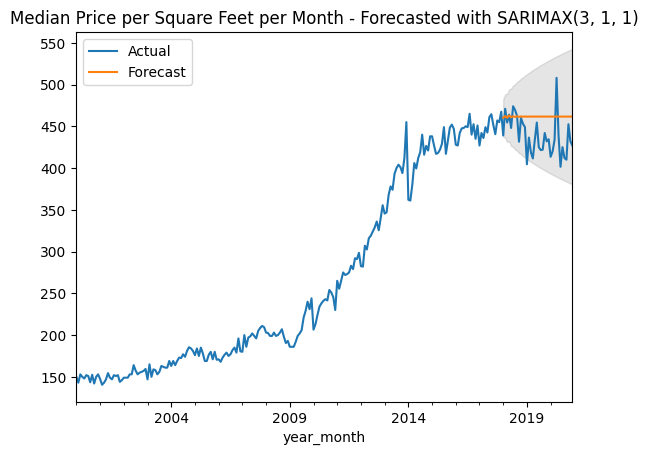

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -828.664
Date:                Fri, 08 Dec 2023   AIC                           1667.327
Time:                        16:11:06   BIC                           1684.180
Sample:                    01-01-2000   HQIC                          1674.137
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7113      0.300     -2.372      0.018      -1.299      -0.123
ar.L2          0.1564      0.142      1.104      0.270      -0.121       0.434
ma.L1          0.3308      0.297      1.113      0.2

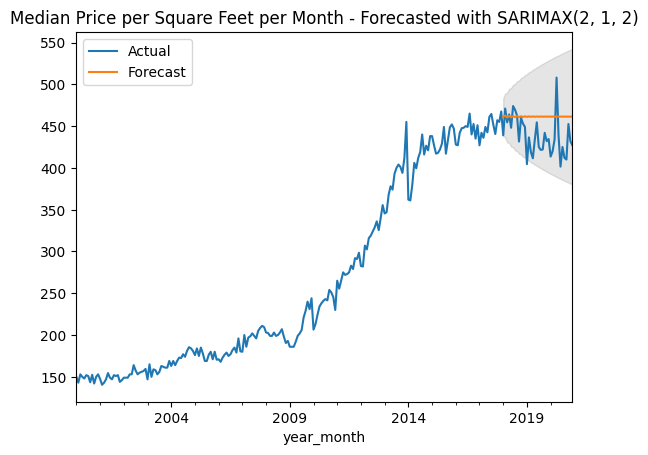

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(2, 2, 7)   Log Likelihood                -818.030
Date:                Fri, 08 Dec 2023   AIC                           1656.060
Time:                        16:11:06   BIC                           1689.720
Sample:                    01-01-2000   HQIC                          1669.662
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2973      1.024     -0.290      0.771      -2.304       1.709
ar.L2          0.4184      0.709      0.590      0.555      -0.972       1.809
ma.L1         -1.1341      1.030     -1.101      0.2

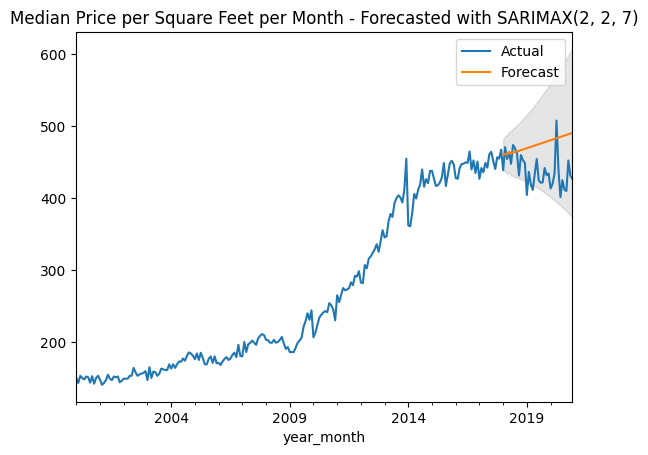

                               SARIMAX Results                                
Dep. Variable:              price_psf   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -829.715
Date:                Fri, 08 Dec 2023   AIC                           1665.430
Time:                        16:11:07   BIC                           1675.542
Sample:                    01-01-2000   HQIC                          1669.515
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0718      0.122      0.588      0.557      -0.168       0.311
ma.L1         -0.4564      0.121     -3.759      0.000      -0.694      -0.218
sigma2       131.5780      7.574     17.372      0.0

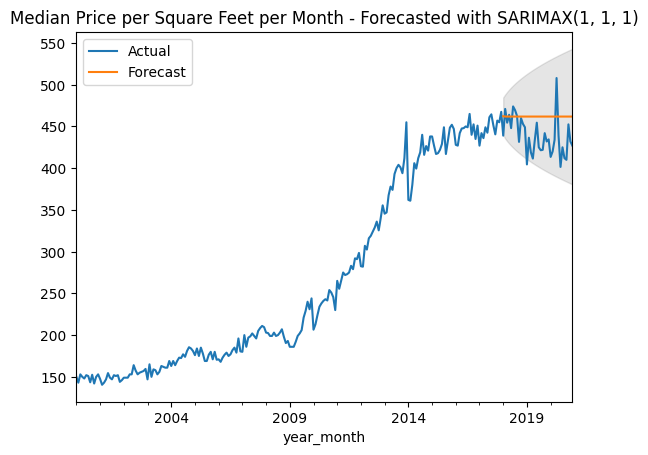

In [293]:
best_orders = [(3, 1, 1), (2, 1, 2), (2, 2, 7), (1, 1, 1)]
forecast_length = 12 * 3

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plot_train_set_median_forecast(SARIMAX, median_monthly_price_psf_train['price_psf'], best_order, forecast_length)

From the plots above, similar to ARIMA, SARIMA(2, 1, 2) is the best model.

### Holt's exponential smoothing on mean `price_psf`

In [294]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

mae, rmse, aic, bic = [], [], [], []
periods = range(1,13)
for period in tqdm(periods, total=len(periods)):
    for fold, (train, test) in enumerate(block_cv(median_monthly_price_psf_train['price_psf'], n_splits=2)):
        fold_mae, fold_rmse, fold_aic, fold_bic = [], [], [], []
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                holtwinters = ETSModel(
                    train, 
                    error='add', 
                    trend='mul', 
                    seasonal='mul', 
                    freq=train.index.inferred_freq, 
                    seasonal_periods=period, 
                    damped_trend=True
                ).fit()
                holtwinters_forecast = holtwinters.forecast(len(test))
                fold_mae.append(np.mean(np.abs(holtwinters_forecast - test)))
                fold_rmse.append(np.sqrt(np.mean((holtwinters_forecast - test) ** 2)))
                fold_aic.append(holtwinters.aic)
                fold_bic.append(holtwinters.bic)
            except:
                fold_mae.append(np.nan)
                fold_rmse.append(np.nan)
                fold_aic.append(np.nan)
                fold_bic.append(np.nan)

    mae.append(mean(fold_mae))
    rmse.append(mean(fold_rmse))
    aic.append(mean(fold_aic))
    bic.append(mean(fold_bic))

df_holtwinters_eval = pd.DataFrame({'periods': periods, 'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic})
df_holtwinters_eval.sort_values(by=['rmse', 'aic', 'bic'], ascending=True)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:01<00:00,  7.71it/s]


,periods,mae,rmse,aic,bic
5,6,10.930475,12.831390,1037.444718,1073.682111
10,11,11.663975,14.765086,1043.964350,1094.139201
9,10,13.041888,15.601938,1048.479115,1095.866475
1,2,13.182743,15.772553,1035.946544,1061.033970
2,3,14.730725,16.691485,1044.069229,1071.944146
8,9,14.474922,16.986647,1050.124916,1094.724784
6,7,16.066989,17.273600,1048.846048,1087.870933
7,8,15.589729,17.722578,1038.403451,1080.215828
4,5,15.578102,17.905457,1047.613951,1081.063852
3,4,16.326089,18.142326,1030.658559,1061.320968


Holt-Winter's exponential smoothing has lowest MAE and RMSE when period is 6.

                                 ETS Results                                  
Dep. Variable:              price_psf   No. Observations:                  216
Model:                      ETS(AMdM)   Log Likelihood                -796.316
Date:                Fri, 08 Dec 2023   AIC                           1630.632
Time:                        16:11:08   BIC                           1694.763
Sample:                    01-01-2000   HQIC                          1656.541
                         - 12-01-2017   Scale                           93.263
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4333      0.070      6.229      0.000       0.297       0.570
smoothing_trend         0.0243      0.011      2.194      0.028       0.003       0.046
smoothing_season

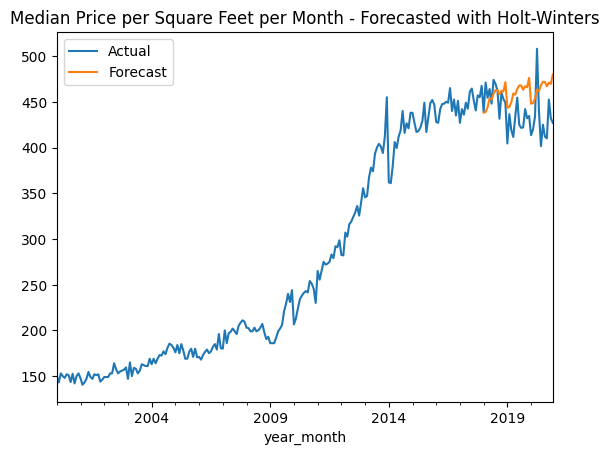

In [295]:
best_period = 6
forecast_length = 36

train = median_monthly_price_psf_train['price_psf'].iloc[:-forecast_length]
val = median_monthly_price_psf_train['price_psf'].iloc[-forecast_length:]

holtwinters = ETSModel(
    train, 
    error='add', 
    trend='mul', 
    seasonal='mul', 
    freq=train.index.inferred_freq, 
    seasonal_periods=period, 
    damped_trend=True
).fit()
holtwinters_forecast = holtwinters.forecast(forecast_length)
print(holtwinters.summary())
print(f'RMSE: {mean_squared_error(val, holtwinters_forecast, squared=False)}')

median_monthly_price_psf_train.plot(
    kind='line',
    title='Median Price per Square Feet per Month - Forecasted with Holt-Winters',
)
holtwinters_forecast.plot(
    kind='line',
)
plt.legend(['Actual', 'Forecast'])
plt.show()

Unfortunately `ETSModel` does not support prediction intervals like `ARIMA` and `SARIMAX`. However, the best model for Holt-Winters has higher RMSE than best model of ARIMA/SARIMAX.

Let's evaluate on test set.

## Evaluate models on median `price_psf` test set

In [296]:
def plot_arma_median_forecast(model, data, order, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    model = model(train, order=order, freq=train.index.inferred_freq)
    model_name = model.__class__.__name__

    model = model.fit()
    model_forecast = model.get_forecast(forecast_length).summary_frame()
    forecast = model_forecast['mean']
    if verbose:
        print(model.summary())
    print(f'RMSE with {model_name}{order}: {mean_squared_error(val, forecast, squared=False)}')
    result = evaluate_model(val, forecast)

    data.plot(
        kind='line',
        title=f'Median Price per Square Feet per Month (2000-2023) - Forecasted with {model_name}{order}',
    )
    forecast.plot(
        kind='line',
    )
    plt.fill_between(model_forecast.index, model_forecast['mean_ci_lower'], model_forecast['mean_ci_upper'], color='k', alpha=0.1)
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'{model_name} {str(order)}',
        **result,
    }

RMSE with ARIMA(3, 1, 1): 25.724750392273116
MSE: 661.7627827447558
RMSE: 25.724750392273116
MAE: 20.843586278156295
MAPE: 0.04520904450829202
R2: -1.1436003817619964
ME: 51.918870465776365
RMSLE: 0.05726248082584042
MPD: 1.4953888514638984
MGD: 0.0033808100834532193


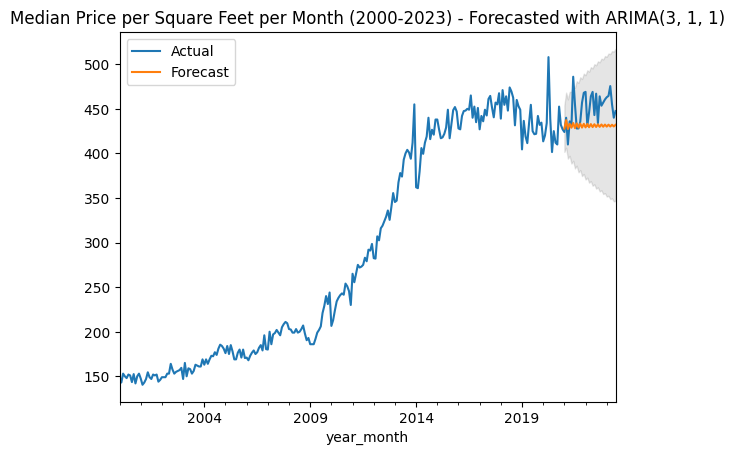

RMSE with ARIMA(2, 1, 2): 28.757711466829363
MSE: 827.0059688094091
RMSE: 28.757711466829363
MAE: 23.627481501490344
MAPE: 0.05127121071448434
R2: -1.6788606985519503
ME: 54.130237000471936
RMSLE: 0.06435951394859019
MPD: 1.8820330924638446
MGD: 0.0042855338934469685


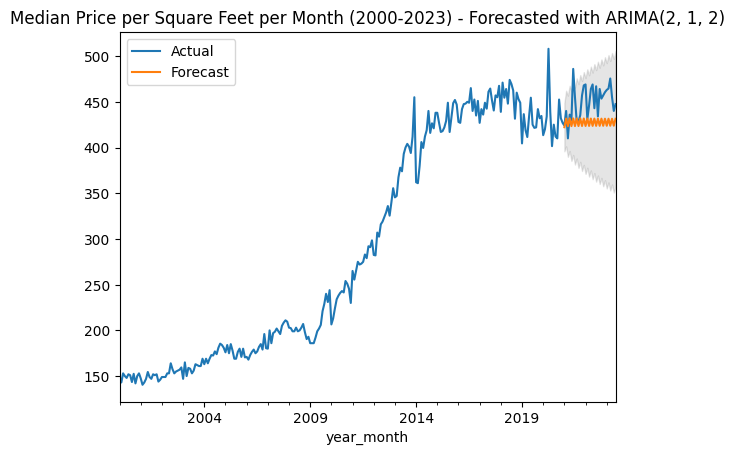

RMSE with ARIMA(2, 2, 7): 36.447948711465045
MSE: 1328.4529652735866
RMSE: 36.447948711465045
MAE: 31.103837312956603
MAPE: 0.06768670493710348
R2: -3.303161733729099
ME: 65.2878759989623
RMSLE: 0.08265817541773554
MPD: 3.0730830946413863
MGD: 0.007114969862868289


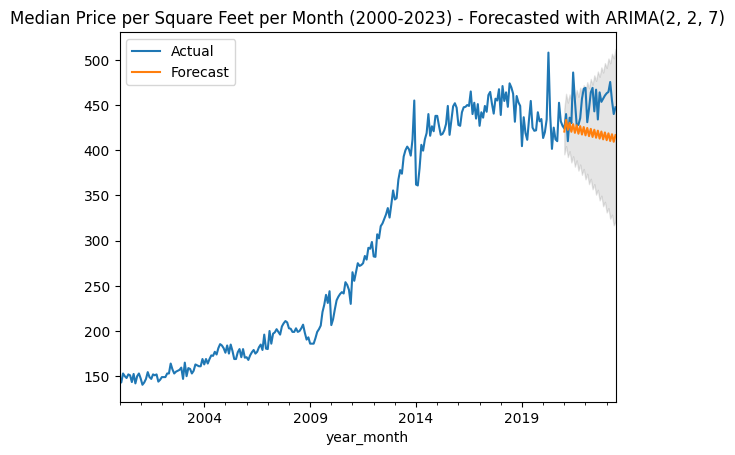

RMSE with ARIMA(1, 1, 1): 27.0093987838982
MSE: 729.5076226676415
RMSE: 27.0093987838982
MAE: 22.377705354850892
MAPE: 0.04860812764969254
R2: -1.3630413483857033
ME: 56.48207264833604
RMSLE: 0.06024218630843098
MPD: 1.652508669441833
MGD: 0.0037452194370662865


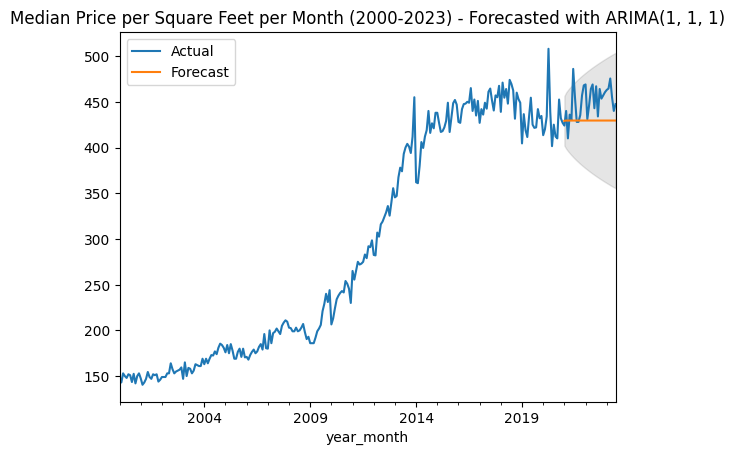

In [297]:
best_orders = [(3, 1, 1), (2, 1, 2), (2, 2, 7), (1, 1, 1)]
forecast_length = 30
arima_test_results = []

median_monthly_price_psf = monthly_price_psf['median_price_psf']

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_median_forecast(ARIMA, median_monthly_price_psf, best_order, forecast_length)
        arima_test_results.append(result)

When evaluating on test set, it seems ARIMA(3, 1, 1) has the lowest RMSE. ARIMA(3, 1, 1) will be chosen as the best model.

RMSE with SARIMAX(3, 1, 1): 25.724750392273116
MSE: 661.7627827447558
RMSE: 25.724750392273116
MAE: 20.843586278156295
MAPE: 0.04520904450829202
R2: -1.1436003817619964
ME: 51.918870465776365
RMSLE: 0.05726248082584042
MPD: 1.4953888514638984
MGD: 0.0033808100834532193


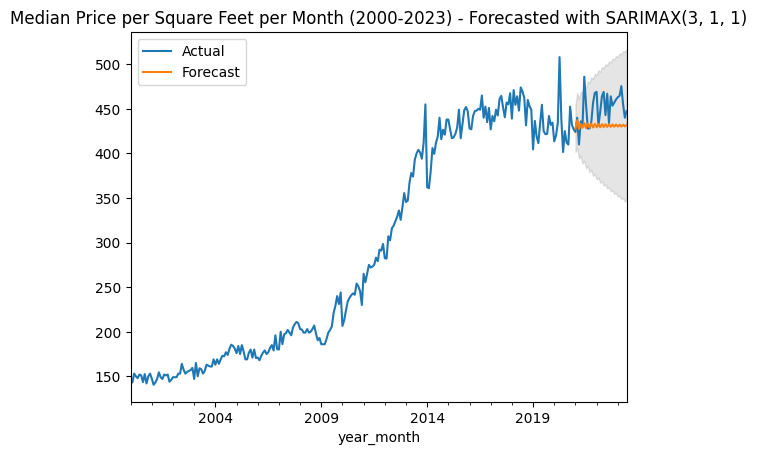

RMSE with SARIMAX(2, 1, 2): 28.757711466829363
MSE: 827.0059688094091
RMSE: 28.757711466829363
MAE: 23.627481501490344
MAPE: 0.05127121071448434
R2: -1.6788606985519503
ME: 54.130237000471936
RMSLE: 0.06435951394859019
MPD: 1.8820330924638446
MGD: 0.0042855338934469685


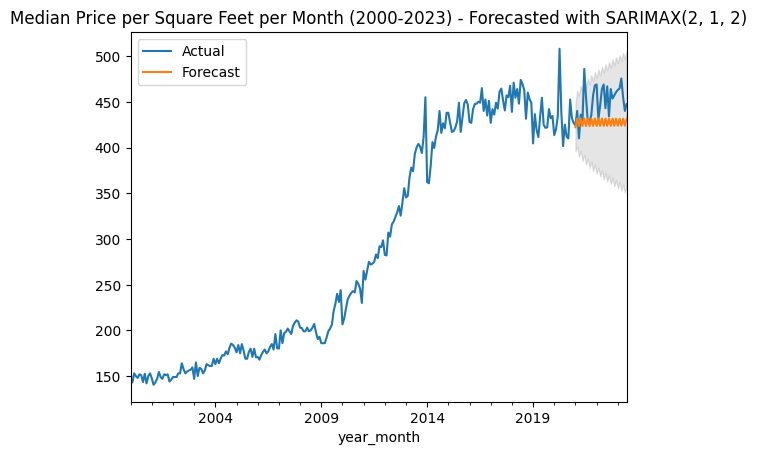

RMSE with SARIMAX(2, 2, 7): 36.447948711465045
MSE: 1328.4529652735866
RMSE: 36.447948711465045
MAE: 31.103837312956603
MAPE: 0.06768670493710348
R2: -3.303161733729099
ME: 65.2878759989623
RMSLE: 0.08265817541773554
MPD: 3.0730830946413863
MGD: 0.007114969862868289


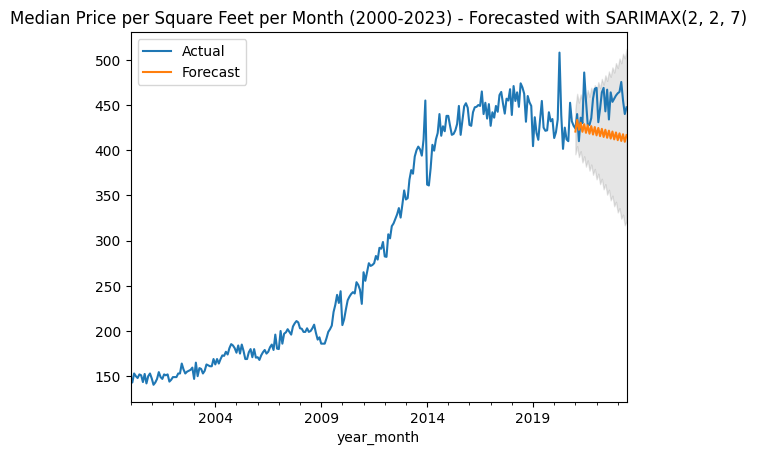

RMSE with SARIMAX(1, 1, 1): 27.0093987838982
MSE: 729.5076226676415
RMSE: 27.0093987838982
MAE: 22.377705354850892
MAPE: 0.04860812764969254
R2: -1.3630413483857033
ME: 56.48207264833604
RMSLE: 0.06024218630843098
MPD: 1.652508669441833
MGD: 0.0037452194370662865


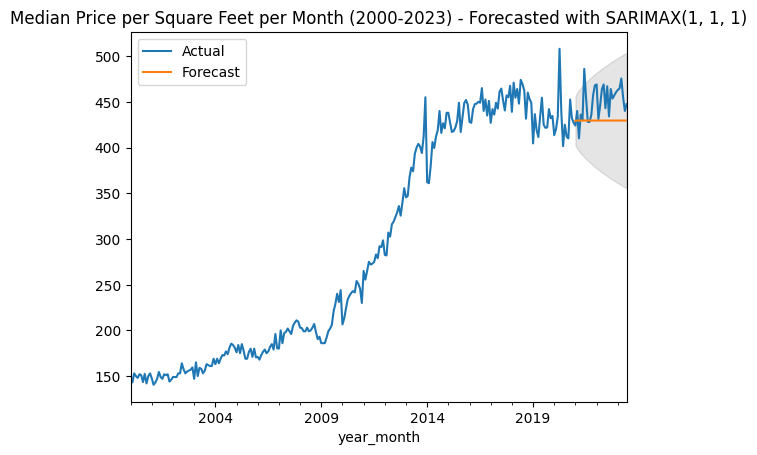

In [298]:
sarima_test_results = []

for best_order in best_orders:
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        result = plot_arma_median_forecast(SARIMAX, median_monthly_price_psf, best_order, forecast_length)
        sarima_test_results.append(result)

When evaluating on test set, it seems SARIMAX(3, 1, 1) has the lowest RMSE. SARIMAX(3, 1, 1) will be chosen as the best model.

In [299]:
def plot_holtwinters_median_forecast(data, period, forecast_length=12, verbose=False):
    train = data.iloc[:-forecast_length]
    val = data.iloc[-forecast_length:]

    holtwinters = ETSModel(
        train, 
        error='add', 
        trend='mul', 
        seasonal='mul', 
        freq=train.index.inferred_freq, 
        seasonal_periods=period, 
        damped_trend=True
    ).fit()
    holtwinters_forecast = holtwinters.forecast(forecast_length)
    if verbose:
        print(holtwinters.summary())
    print(f'RMSE: {mean_squared_error(val, holtwinters_forecast, squared=False)}')
    result = evaluate_model(val, holtwinters_forecast)

    data.plot(
        kind='line',
        title='Median Price per Square Feet per Month (2000-2023) - Forecasted with Holt-Winters',
    )
    holtwinters_forecast.plot(
        kind='line',
    )
    plt.legend(['Actual', 'Forecast'])
    plt.show()

    return {
        'model': f'Holt-Winters (p={period})',
        **result,
    }

RMSE: 32.737218158559706
MSE: 1071.7254527611315
RMSE: 32.737218158559706
MAE: 27.882077568961613
MAPE: 0.06066283021478002
R2: -2.4715628463634927
ME: 60.39081700060575
RMSLE: 0.07380180784220523
MPD: 2.461028455815369
MGD: 0.005655563932343618


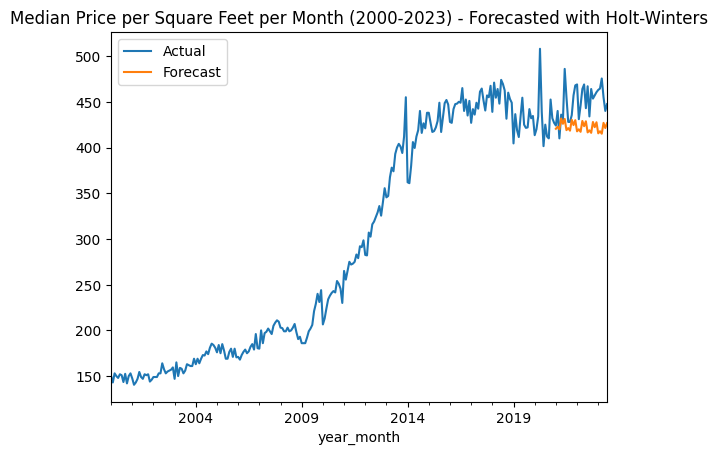

In [300]:
best_period = 6
holtwinters_test_results = []

result = plot_holtwinters_median_forecast(median_monthly_price_psf, best_period, forecast_length)
holtwinters_test_results.append(result)

## Statistical evaluation on median `price_psf` test set

Similar to mean `price_psf`, We will employ three statistical tests to evaluate the performance of the models:
1. Friedman test
2. Iman-Davenport test
3. Nemenyi post-hoc test

These can be performed via the following steps as outlined in Zhan et al. (2023):
1. Ranking the performance of each algorithm according to different evaluation measures to obtain an average ranking for each algorithm;
2. Using Friedman and Iman–Davenport to test whether the algorithms all perform equally; 
3. Utilizing the Nemenyi post-hoc test to further distinguish between the algorithms.

In [301]:
median_price_psf_test_results = arima_test_results + sarima_test_results + holtwinters_test_results

df_median_price_psf_test_results = pd.DataFrame(median_price_psf_test_results)
df_median_price_psf_test_results

,model,mse,rmse,...,rmsle,mpd,mgd
0,"ARIMA (3, 1, 1)",661.762783,25.724750,...,0.057262,1.495389,0.003381
1,"ARIMA (2, 1, 2)",827.005969,28.757711,...,0.064360,1.882033,0.004286
2,"ARIMA (2, 2, 7)",1328.452965,36.447949,...,0.082658,3.073083,0.007115
3,"ARIMA (1, 1, 1)",729.507623,27.009399,...,0.060242,1.652509,0.003745
4,"SARIMAX (3, 1, 1)",661.762783,25.724750,...,0.057262,1.495389,0.003381
5,"SARIMAX (2, 1, 2)",827.005969,28.757711,...,0.064360,1.882033,0.004286
6,"SARIMAX (2, 2, 7)",1328.452965,36.447949,...,0.082658,3.073083,0.007115
7,"SARIMAX (1, 1, 1)",729.507623,27.009399,...,0.060242,1.652509,0.003745
8,Holt-Winters (p=6),1071.725453,32.737218,...,0.073802,2.461028,0.005656


### Assign rank to each model based on each evaluation metric

In [302]:
for metric in metrics:
    df_median_price_psf_test_results['rank_' + metric] = df_median_price_psf_test_results[metric].rank()

df_median_price_psf_test_results

,model,mse,rmse,...,rank_rmsle,rank_mpd,rank_mgd
0,"ARIMA (3, 1, 1)",661.762783,25.724750,...,1.5,1.5,1.5
1,"ARIMA (2, 1, 2)",827.005969,28.757711,...,5.5,5.5,5.5
2,"ARIMA (2, 2, 7)",1328.452965,36.447949,...,8.5,8.5,8.5
3,"ARIMA (1, 1, 1)",729.507623,27.009399,...,3.5,3.5,3.5
4,"SARIMAX (3, 1, 1)",661.762783,25.724750,...,1.5,1.5,1.5
5,"SARIMAX (2, 1, 2)",827.005969,28.757711,...,5.5,5.5,5.5
6,"SARIMAX (2, 2, 7)",1328.452965,36.447949,...,8.5,8.5,8.5
7,"SARIMAX (1, 1, 1)",729.507623,27.009399,...,3.5,3.5,3.5
8,Holt-Winters (p=6),1071.725453,32.737218,...,7.0,7.0,7.0


In [303]:
df_median_price_psf_test_results['mean_rank'] = df_median_price_psf_test_results[[col for col in df_median_price_psf_test_results.columns if 'rank' in col]].mean(axis=1)
df_median_price_psf_test_results

,model,mse,rmse,...,rank_mpd,rank_mgd,mean_rank
0,"ARIMA (3, 1, 1)",661.762783,25.724750,...,1.5,1.5,2.277778
1,"ARIMA (2, 1, 2)",827.005969,28.757711,...,5.5,5.5,5.166667
2,"ARIMA (2, 2, 7)",1328.452965,36.447949,...,8.5,8.5,7.722222
3,"ARIMA (1, 1, 1)",729.507623,27.009399,...,3.5,3.5,4.055556
4,"SARIMAX (3, 1, 1)",661.762783,25.724750,...,1.5,1.5,2.277778
5,"SARIMAX (2, 1, 2)",827.005969,28.757711,...,5.5,5.5,5.166667
6,"SARIMAX (2, 2, 7)",1328.452965,36.447949,...,8.5,8.5,7.722222
7,"SARIMAX (1, 1, 1)",729.507623,27.009399,...,3.5,3.5,4.055556
8,Holt-Winters (p=6),1071.725453,32.737218,...,7.0,7.0,6.555556


### Friedman test

H0: All models perform equally well.

H1: At least one model performs differently.

In [304]:
number_of_models = len(df_median_price_psf_test_results)
number_of_metrics = len(metrics)

t_chi_square = 12 * number_of_metrics / (number_of_metrics * (number_of_metrics + 1)) * \
    sum((df_median_price_psf_test_results['mean_rank'] - ((number_of_models * + 1) / 2)) ** 2)
print(f'Degrees of freedom (k-1): {number_of_models - 1}')
print(f't_chi_square: {t_chi_square}')

Degrees of freedom (k-1): 8
t_chi_square: 43.38148148148149


In [305]:
from scipy.stats import friedmanchisquare

friedmanchisquare(*df_median_price_psf_test_results[metrics].values)

FriedmanchisquareResult(statistic=42.084291187739495, pvalue=1.3057998372399848e-06)

With DOF = 8 at alpha = 0.05, the critical value is 15.51 (see [link](ttps://people.smp.uq.edu.au/YoniNazarathy/stat_models_B_course_spring_07/distributions/chisqtab.pdf)).

Since the computed statistic is more than the critical value, we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

### Iman-Davenport test

H0: All models perform equally well.

H1: At least one model performs differently.

In [306]:
t_chi_square = 46.26
d = 5
k = 9

(d - 1) * t_chi_square / (d * (k - 1) - t_chi_square)

-29.559105431309913

In [307]:
t_F = (number_of_metrics - 1) * t_chi_square / (number_of_metrics * (number_of_models - 1) - t_chi_square)
print(f'Degrees of freedom 1 (d-1): {number_of_metrics - 1}')
print(f'Degrees of freedom 2 (d-1)(k-1): {(number_of_metrics - 1) * (number_of_models - 1)}')
print(f't_F: {t_F}')

Degrees of freedom 1 (d-1): 8
Degrees of freedom 2 (d-1)(k-1): 64
t_F: 14.377622377622377


With DOF1 = 4 and DOF2 = 32 at alpha = 0.05, the critical value is 2.668 (see [link](https://www.stat.purdue.edu/~lfindsen/stat503/F_alpha_05.pdf)).

Since the computed statistic is less than the critical value, we fail to reject the null hypothesis H0 and conclude that there is no statistically significant difference in the performance of all algorithms.

However, the Iman-Davenport test is only useful when 𝑑 becomes larger, as 𝑇𝜒2 will gradually be biased towards chi-square random variables with degrees of freedom 𝑘 − 1. However we only have d = 5 hence we will drop this.

### Nemenyi post-hoc test

We can conduct the Nemenyi post-hoc test to find exactly which groups have different means.

In [308]:
critical_distance = 3.102 * np.sqrt((number_of_models * (number_of_metrics + 1)) / (6 * number_of_metrics))
critical_distance

4.0046647799784685

In [309]:
distance_between_models = []

for rank in df_median_price_psf_test_results['mean_rank']:
    distance_between_models.append(np.abs(rank - df_median_price_psf_test_results['mean_rank']))

df_distance_between_models = pd.DataFrame(distance_between_models).reset_index(drop=True)
df_distance_between_models

,0,1,2,...,6,7,8
0,0.000000,2.888889,5.444444,...,5.444444,1.777778,4.277778
1,2.888889,0.000000,2.555556,...,2.555556,1.111111,1.388889
2,5.444444,2.555556,0.000000,...,0.000000,3.666667,1.166667
3,1.777778,1.111111,3.666667,...,3.666667,0.000000,2.500000
4,0.000000,2.888889,5.444444,...,5.444444,1.777778,4.277778
5,2.888889,0.000000,2.555556,...,2.555556,1.111111,1.388889
6,5.444444,2.555556,0.000000,...,0.000000,3.666667,1.166667
7,1.777778,1.111111,3.666667,...,3.666667,0.000000,2.500000
8,4.277778,1.388889,1.166667,...,1.166667,2.500000,0.000000


At alpha = 0.05, we can conclude that ARIMA(2, 2, 7) and SARIMA(2, 2, 7) has statistically significant underperformance than the other models.

In [310]:
df_median_price_psf_test_results[metrics].T.rename(columns=df_median_price_psf_test_results['model']).reset_index(drop=True)

,"ARIMA (3, 1, 1)","ARIMA (2, 1, 2)","ARIMA (2, 2, 7)",...,"SARIMAX (2, 2, 7)","SARIMAX (1, 1, 1)",Holt-Winters (p=6)
0,661.762783,827.005969,1328.452965,...,1328.452965,729.507623,1071.725453
1,20.843586,23.627482,31.103837,...,31.103837,22.377705,27.882078
2,25.724750,28.757711,36.447949,...,36.447949,27.009399,32.737218
3,0.045209,0.051271,0.067687,...,0.067687,0.048608,0.060663
4,-1.143600,-1.678861,-3.303162,...,-3.303162,-1.363041,-2.471563
5,51.918870,54.130237,65.287876,...,65.287876,56.482073,60.390817
6,0.057262,0.064360,0.082658,...,0.082658,0.060242,0.073802
7,1.495389,1.882033,3.073083,...,3.073083,1.652509,2.461028
8,0.003381,0.004286,0.007115,...,0.007115,0.003745,0.005656


d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

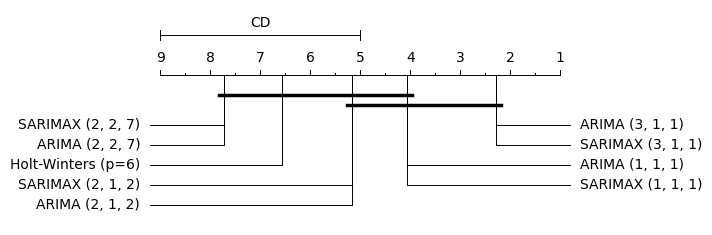

In [311]:
from autorank import autorank, plot_stats

result = autorank(df_median_price_psf_test_results[metrics].T.rename(columns=df_median_price_psf_test_results['model']).reset_index(drop=True), alpha=0.05, verbose=False, order='ascending')
plot_stats(result, allow_insignificant=True)
plt.show()

## Concluding remarks

The best models chosen from the analysis are:
- Mean `price_psf`: ARIMA/SARIMAX(2, 2, 4) with RMSE of 25.282463069008642
- Median `price_psf`: ARIMA/SARIMAX(3, 1, 1) with RMSE of 25.724750392273116

The best models are estimated from ACF and PACF plots.

The next step is to perform modelling with machine learning methods. However, time series methods cannot be compared directly with machine learning models because the latter incorporate other features, which are useful external information.